In [25]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [175]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import wget
import os
import shutil
import datetime
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator

from category_encoders import *

from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from math import sqrt

warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 0. Functions
- Run below cell once

In [132]:
{
    "tags": [
        "hide_input",
    ]
}

# ----------------------------------#### BUILD DATASETS ####------------------------------------------------------------------------------------------------------

def Update_Data():
    urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
            'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']

    for url in urls:
        filename = wget.download(url)
        os.remove(dataPath + filename)
        newPath = shutil.move(filename, dataPath[0:-1])
        
    conf_df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv(dataPath + 'time_series_covid19_deaths_global.csv') 
    conf_df_less_states = update_initial_dfs(conf_df)
    deaths_df_less_states = update_initial_dfs(deaths_df)
    return conf_df, deaths_df, conf_df_less_states, deaths_df_less_states

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
def update_initial_dfs(df):
    
    df['Province/State'].fillna(df['Country/Region'], inplace=True)
    listProvince = df['Province/State'].unique().tolist()
    listCountry = df['Country/Region'].unique().tolist()

    # Remove state entries for countries 'Australia', 'Canada' & 'China' & aggregate state numbers for country total:
    notAggregatedCountries = [x for x in listCountry if x not in listProvince] 
  
    df1 = df[~df['Country/Region'].isin(notAggregatedCountries)]
    
    for i, agg_country in enumerate(notAggregatedCountries):
        dfTemp = df[df['Country/Region'] == agg_country]
        provState = agg_country #+ '_Total'          # Countries with the sum of their states
        lat = dfTemp.Lat.sum()/len(dfTemp)          # i.e. Australia with Victoria, NSW etc aggregated
        long = dfTemp.Long.sum()/len(dfTemp)
        rowEntries = [provState, agg_country, lat, long]
        lstRow = [elem for elem in rowEntries] 
        for col in dfTemp.columns[4:]:
            col_j_aggregate = dfTemp[col].sum()
            lstRow.append(col_j_aggregate)
        lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
        df1 = df1.append(lstRow)
   
    # Countries not including their colonial states
    df1 = df1.reset_index(drop = True)                                # i.e. United Kingdom without the "Falkland Islands"

    return df1

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def create_changes_dataframe(df):
    
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()
    
    # STEP_1:
    # Some countries have individual states listed: Aggregate state-values together to gain actual country values
    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        if len(dfTemp) > 1:
            provState = agg_country + '_Total'         # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)         # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
            df = df.append(lstRow)
    
    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'], inplace=True)  # Countries not including their colonial states
    df = df.reset_index(drop = True)                                 # i.e. United Kingdom without the "Falkland Islands"
    
    # STEP_2:
    # Make new columns to represent daily changes and convert US date-format to dd/mm/yy
    col_list = df.columns[0:4].tolist()
    for col in df.columns[4:]:
        if len(col) == 8: 
            col = "Diff_Prev_Day_" + col[3:5] + col[2] + col[0:2] # i.e. '12/12/20'
        elif len(col) == 7:
            col = "Diff_Prev_Day_" + col[2:4] + col[1] + col[0] # i.e.   '2/12/20'
        elif len(col) == 6:
            col = "Diff_Prev_Day_" + col[2:3] + col[1] + col[0] # i.e.   '2/2/20'
        col_list.append(col)
        
    ## STEP_3:
    # Define new dataframe to represent daily changes
    df_daily_change = pd.DataFrame(columns = col_list)
    countries_unique = df["Country/Region"].unique()
    growth_rates = []
    prevNum = 0
    len_max = len(df.columns[4:])
    
    ## STEP_4:
    # a) Iterate through each country and respective regions:
    for country in countries_unique:       
        df_country = df[df["Country/Region"] == country]
        province_states_unique = df_country["Province/State"].dropna()

        for province_state in province_states_unique:

            # b) Start dataframe recording from first registered case: (ignore all prior zero-cases on earlier dates)
            df_province_state = df_country[df_country["Province/State"] == province_state]
            df_province_state = df_province_state.loc[:, (df_province_state != 0).any(axis=0)]
            
            # d) Save first four columns (Province, Country, Lat, Long)
            #    Determine how many days prior to first case recorded (pad with 0)
            day_change_lst = df_province_state[df_province_state.columns[0:4]].values[0].tolist() 
            diff = len_max - len(df_province_state.columns[4:])
            day_change_lst += [0] * (diff) 
     
            
            # e) Calculate change from one-day to the next
            totalCases = 0
            for col in df_province_state.columns[4:]:
                new_num_cases = df_province_state[col].values[0]
                change_cases = new_num_cases - totalCases
                totalCases = new_num_cases
                day_change_lst.append(change_cases)

            df_day_i_change = pd.DataFrame([day_change_lst], columns = col_list)

            if len(df_daily_change) == 0:
                df_daily_change = df_day_i_change
            else:
                df_daily_change = pd.concat([df_daily_change, df_day_i_change])
    
    return df_daily_change

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ----------------------------------#### FILTERING ####------------------------------------------------------------------------------------------------------

def lowpass_butterworth(y, cutoff, order, Ts, inputVariable = None):
   
    # Detrend
    if type(y) == pd.DataFrame:
        #variable = inputVariable 
        # Detrend
        y_ = y[inputVariable].dropna() - (y[inputVariable].dropna()).sum() / len(y[inputVariable].dropna())
        # Sample-rate
        fs = 1 / Ts
        # Low-pass calculation
        b, a = return_filter_coeffs(cutoff, fs, order=order)
        y_butter = lfilter(b, a, y_) + (y[inputVariable].dropna()).sum() / len(y[inputVariable].dropna())
        
    else:
        y_ = y - sum(y)/len(y)

        # Low-pass calculation
        fs = 1 / Ts
        b, a = return_filter_coeffs(cutoff, fs, order=order)
        y_butter = lfilter(b, a, y_) + sum(y) / len(y)

    return y_butter

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def return_filter_coeffs(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# ---------------------------------------------------------------------------------------------------------------------

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = return_filter_coeffs(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------#### PLOTTING ####------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def getcolour():
    return np.random.rand(3,)

def plotResults(df, x, labels, dict_candidates_, log_scaling = False, stemplot = False, filterInputs_ = None):
    f = plt.figure(figsize=(15,15))
    
    for i, region in enumerate(dict_candidates_):  
        axi = f.add_subplot(str(len(dict_candidates_)) +"1" + str(i + 1))

        for j, location in enumerate(dict_candidates_[region]):
            y = df[df['Province/State'] == location].values[0][4:].tolist()
            
            if filterInputs_ is not None:
                Ts = filterInputs_[0] 
                order = filterInputs_[1] 
                cutoff = filterInputs_[2] 
                y = lowpass_butterworth(np.array(y), cutoff, order, Ts)
                #df_plot["y_filtered"] = y_filtered
                #df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()

            if stemplot:
                plt.bar(x, y, alpha = 0.5, width = 0.1, label = location)
                plt.plot(x, y,  'o')
            else:
                plt.plot(x, y, alpha = 0.5, linewidth = 2, label = location)
                
        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        axi.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        plt.title(region, size = 20)
        plt.legend(loc = "upper left")

        if log_scaling: 
            axi.set_yscale('log')
            plt.ylim([0, 10e6])

    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

    
def plotBarPlots(df, list_countries, colourList, axislabels, filterInputs, plotAbsoluteCases = False):
    
    filtering = filterInputs[0]
    Ts = filterInputs[1]
    order = filterInputs[2]
    cutoff = filterInputs[3]
    
    f = plt.figure(figsize=(20,10))
    ax = f.add_subplot("111")
    
    if plotAbsoluteCases:
        for i, country in enumerate(list_countries):
            df_ = df[df['Country/Region'] == country]
            x = df_.columns[3:].tolist()
            y = df_[df_.columns[3:]].values.tolist()[0]
            plt.plot(x, y, '<-', label = country)
            plt.legend()
        plt.xticks(rotation=45)
        plt.ylabel(axislabels[0], size = 15)
        plt.xlabel("Date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
        return
            
    else:
        df_plot = pd.DataFrame()
        base = datetime.date(2020, 1, 22)
        numdays = len(df.columns[4:])
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        province_states_unique = df["Province/State"].unique()
        inputVariable = "DayChanges"
        j = 0
        for province_state in province_states_unique:
            df_province_state = df[df["Province/State"] == province_state]
            dayChanges = df_province_state[df_province_state.columns[4:]].values[0]

            if max(dayChanges) > 0 and (province_state in list_countries):
                #j += 1
                if j%1 == 0:
                    colour = colourList[j]
                    j += 1
                    df_plot["dates"] = date_list
                    df_plot["DayChanges"] = dayChanges
                    #df_plot["growth_rates"] = df_plot["growth_rates"].rolling(3).mean()
                    if filtering:
                        y_filtered = lowpass_butterworth(df_plot, cutoff, order, Ts, inputVariable)
                        df_plot["y_filtered"] = y_filtered
                        df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()
                        if j%2 == 0:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                        else:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                    else:
                         plt.bar(df_plot.dates, df_plot.DayChanges, color = colour, label = province_state, linewidth = 1, alpha = 0.2)

            #break
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #import matplotlib.dates.WeekdayLocator
    # tick on mondays every week
    #loc = WeekdayLocator(byweekday=MO, tz=tz)

    # tick on mondays and saturdays
    loc = WeekdayLocator(byweekday=(MO,FR))
    ax.xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.ylabel(axislabels[0], size = 15)
    plt.xlabel("Date", size = 15)
    #plt.xlim(df_plot.dates[15], df_plot.dates[len(df_plot.dates) - 1])
    plt.gca().set_xlim(left=df_plot.dates[20])
    plt.title(axislabels[1], size = 20)
    #plt.ylim([-1, 100])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------------------------

#### --------------------------------------------- PREDICTIONS + PLOTTING --------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------

def polyPolyRegPrediction(df, labels, countryList, degreeList, pred_window):
    f = plt.figure(figsize=(15,12))
    for i, country in enumerate(countryList):
        axi = f.add_subplot(str(len(countryList)) +"1" + str(i + 1))
        deg = degreeList[i]
        df_country = df[df['Province/State'] == country] 
        x = np.linspace(0, len(df_country[df_country.columns[4:]].values[0])-1, len(df_country[df_country.columns[4:]].values[0]))
        coeffs = np.polyfit(x, df_country[df_country.columns[4:]].values[0], deg)

        x_new = np.linspace(0, len(df_country[df_country.columns[4:]].values[0])-1 + pred_window, len(df_country[df_country.columns[4:]].values[0])+ pred_window)

        y_new = 0
        for i, coeff in enumerate(coeffs):
            power = len(coeffs) - 1 - i
            y_new += coeff * x_new ** power 

        base = datetime.date(2020, 1, 22)
        numdays = len(x_new)
        date_list_pred = [base + datetime.timedelta(days=x) for x in range(numdays)]
        plt.plot(date_list_pred, y_new, '--', linewidth = 3, label = country + ' model fit & prediction', alpha = 0.6)
        numdays = len(x)
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        plt.plot(date_list, df_country[df_country.columns[4:]].values[0], label = country)
        plt.legend(loc = "upper left")
        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
        axi.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        #plt.title(region, size = 20)
        plt.legend(loc = "upper left")


    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)
    
# ------------------------------------------------------------------------------------------------------------------------------------------------------
    

def plotGaussPredictions(df, labels, countryList, pred_window, alphaNoise, kernel_, filterInputs_ = None):
    f = plt.figure(figsize=(15, 12))

    for i, country in enumerate(countryList):

        df_country = df[df['Province/State'] == country] 
        x = np.linspace(0, len(df_country[df_country.columns[4:]].values[0])-1, len(df_country[df_country.columns[4:]].values[0]))

        X_train = np.atleast_2d(x).T
        y_train = np.array(df_country[df_country.columns[4:]].values[0])

        gpm = GaussianProcessRegressor(kernel=kernel_, n_restarts_optimizer=3, alpha=alphaNoise)
        if (filterInputs_ is not None) & filterInputs_[0]:
            Ts = filterInputs_[1] 
            order = filterInputs_[2] 
            cutoff = filterInputs_[3] 
            y_train = lowpass_butterworth(np.array(y_train), cutoff, order, Ts)

        gpm.fit(X_train, y_train)
        x_max = X_train.max() + pred_window
        x_min = 0
        X_ = np.linspace(x_min, x_max, int((x_max-x_min)/10)+1)
        ypm, ysm = gpm.predict(X_[:, np.newaxis], return_std=True)

        # plot prediction for msn
        ax = f.add_subplot(str(len(countryList)) +"1" + str(i + 1))

        minVal = min(min(ypm-1.960*ysm), min(y_train))
        maxVal = max(max(ypm+1.960*ysm), max(y_train))
        ax.plot(X_, ypm, lw=0.7, zorder=9, color = 'b', linestyle = '--', label = country + ' predicted curve') 
        ax.fill_between(X_, ypm-1.960*ysm, ypm+1.960*ysm, alpha=0.1, color = 'b', label = country + ' confidence interval') 
        ax.plot(X_train, y_train, 'r-', label = country + ' ground truth')
        #plt.plot([end_cycles, end_cycles], [minVal, maxVal], color = 'y', linestyle = '--', label = 'prediction start')
        plt.legend()
        
        base = datetime.date(2020, 1, 22)
        numdays = len(X_)
        date_list_pred = [base + datetime.timedelta(days=x) for x in range(numdays)]
        #plt.plot(date_list_pred, y_new, '--', linewidth = 3, label = country + ' model fit & prediction', alpha = 0.6)
        numdays = len(x)
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        #plt.plot(date_list, df_country[df_country.columns[4:]].values[0], label = country)
        plt.legend(loc = "upper left")
        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        #plt.title(region, size = 20)
        plt.legend(loc = "upper left")


    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)
    
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

#### 1. Update Datasets
- Run below cell once

In [141]:
conf_df, deaths_df, conf_df_less_states, deaths_df_less_states = Update_Data()
changes_conf_df = create_changes_dataframe(conf_df_less_states)
changes_deaths_df = create_changes_dataframe(deaths_df_less_states)

100% [..........................................................] 93246 / 93246

#### 2. EDA: Visualisation of several countries

##### Here we will analyse 4 parts of the world:
1. Selected European Countries/Neighbours
        - Part 1: Germany, Sweden, United Kingdom, Russia
        - Part 2: France, Italy, Spain, Turkey
- North & South America
        - USA, Canada, Brazil, Mexico
- Asia
        - South Korea, India, China, Afghanistan
- Australia (with states) & New Zealand
        - Victoria, New South Wales, Australia-Total, New Zealand

##### Define required variables:

In [142]:
dict_candidates = {}
dict_candidates['Europe A'] = ['Germany', 'Sweden', 'United Kingdom', 'Russia']
dict_candidates['Europe B'] = ['France', 'Italy', 'Spain', 'Turkey']
dict_candidates['Asia'] = ['Korea, South', 'India', 'China', 'Afghanistan']
dict_candidates['North & South America'] = ['US', 'Canada', 'Brazil', 'Mexico']
dict_candidates['Australasia'] = ['Australia', 'New Zealand', 'Indonesia']
x = conf_df.columns[4:].tolist()

#### ------------------------------------------------------ Visualisation: Country line plots -----------------------------------------------------------------------------------

##### 2.1 Confirmed number of cases

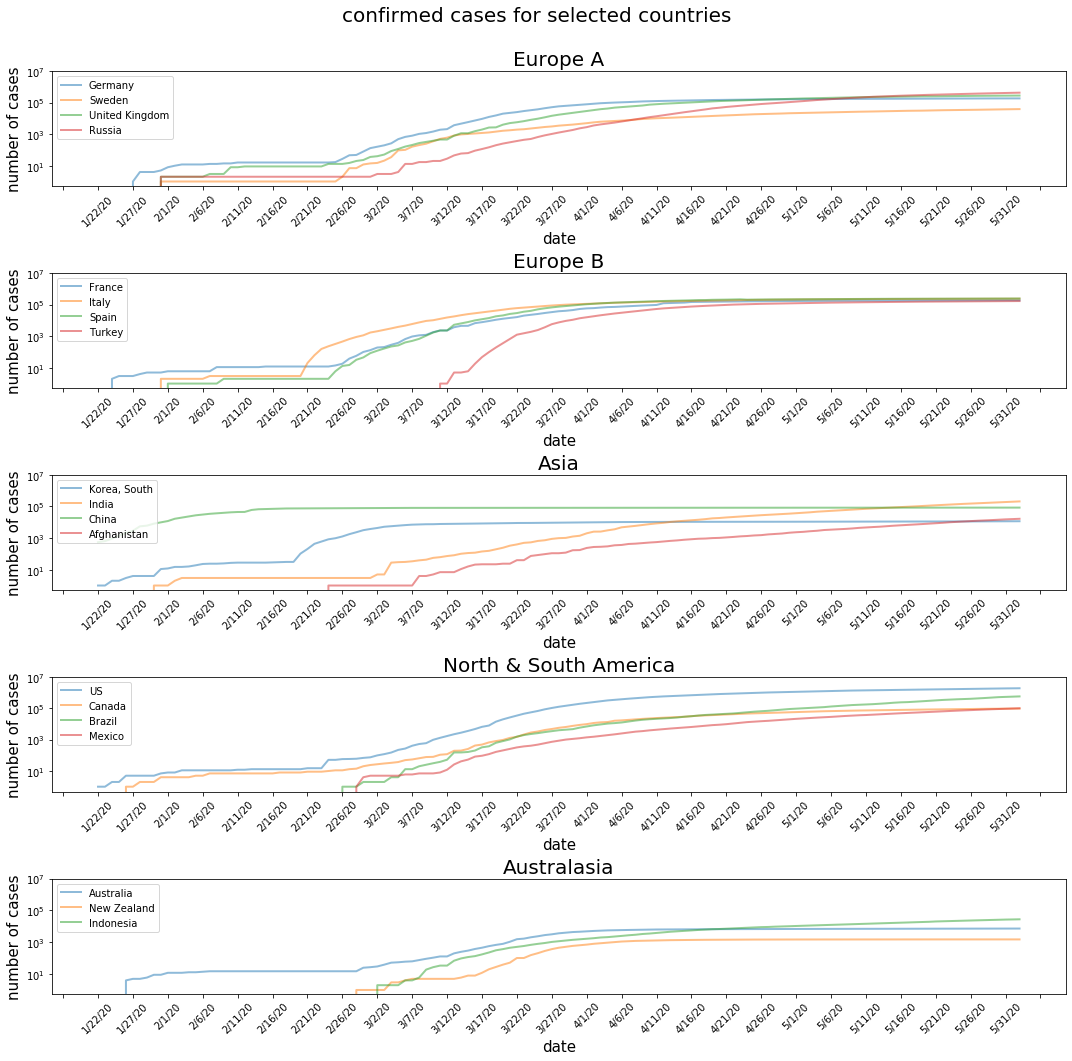

In [144]:
log_scaling = True
labels = ['number of cases', 'confirmed cases']
plotResults(conf_df_less_states, x, labels, dict_candidates, log_scaling)

##### 2.2 Confirmed number of deaths

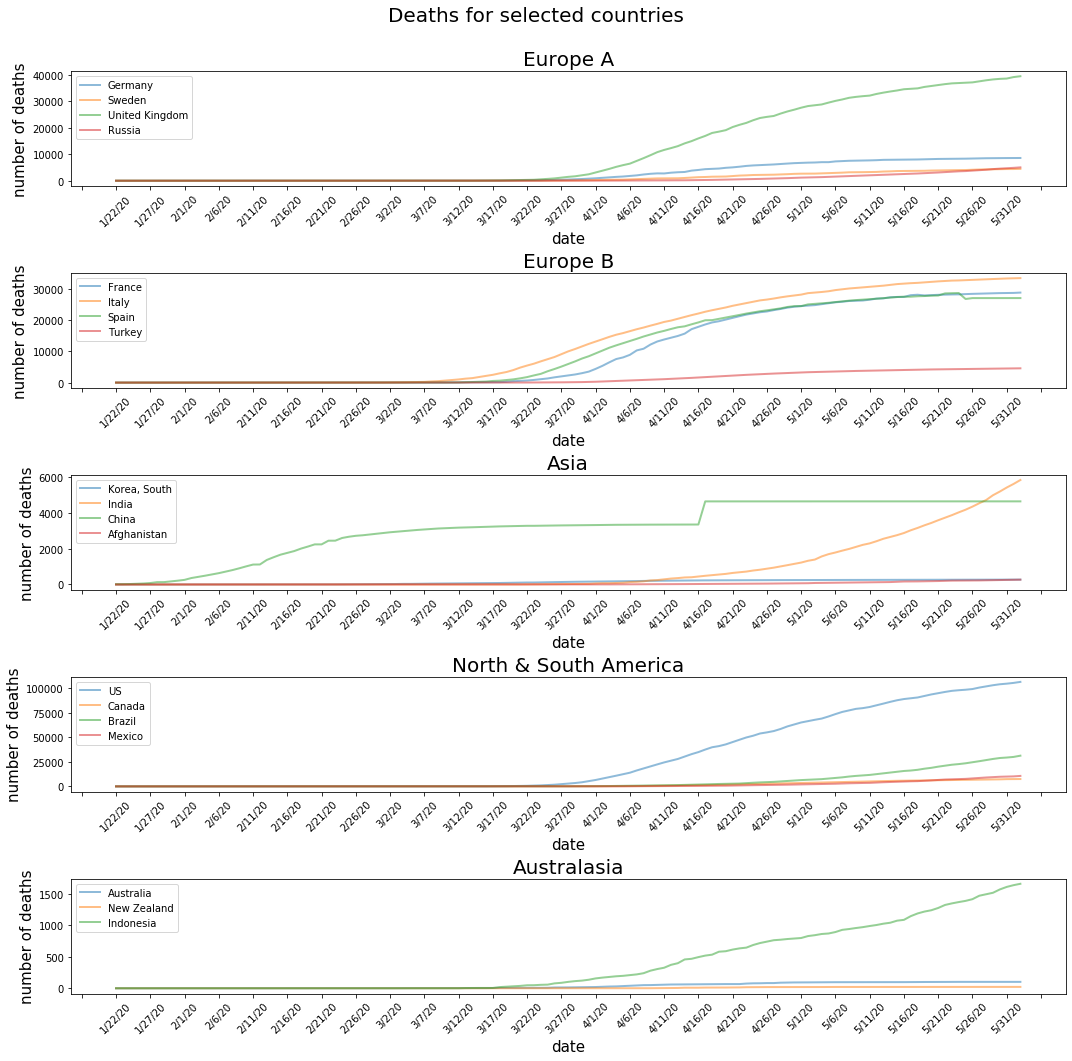

In [145]:
labels = ['number of deaths', 'Deaths']
plotResults(deaths_df_less_states, x, labels, dict_candidates)

##### 2.3 Newly confirmed cases per day

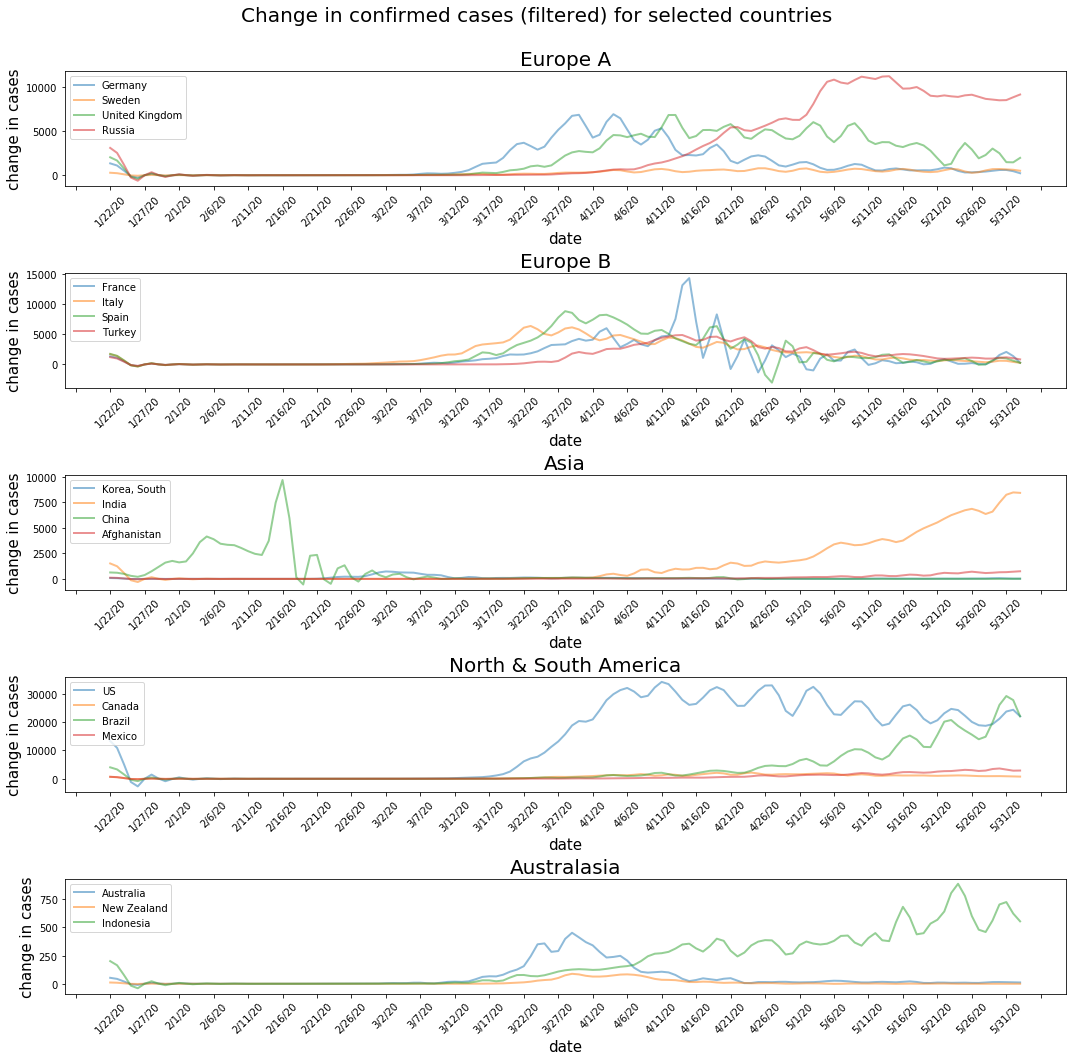

In [146]:
labels = ['change in cases', 'Change in confirmed cases (filtered)']
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [Ts, order, cutoff]
plotResults(changes_conf_df, x, labels, dict_candidates, filterInputs_ = filterInputs)

##### 2.4 Newly confirmed deaths per day

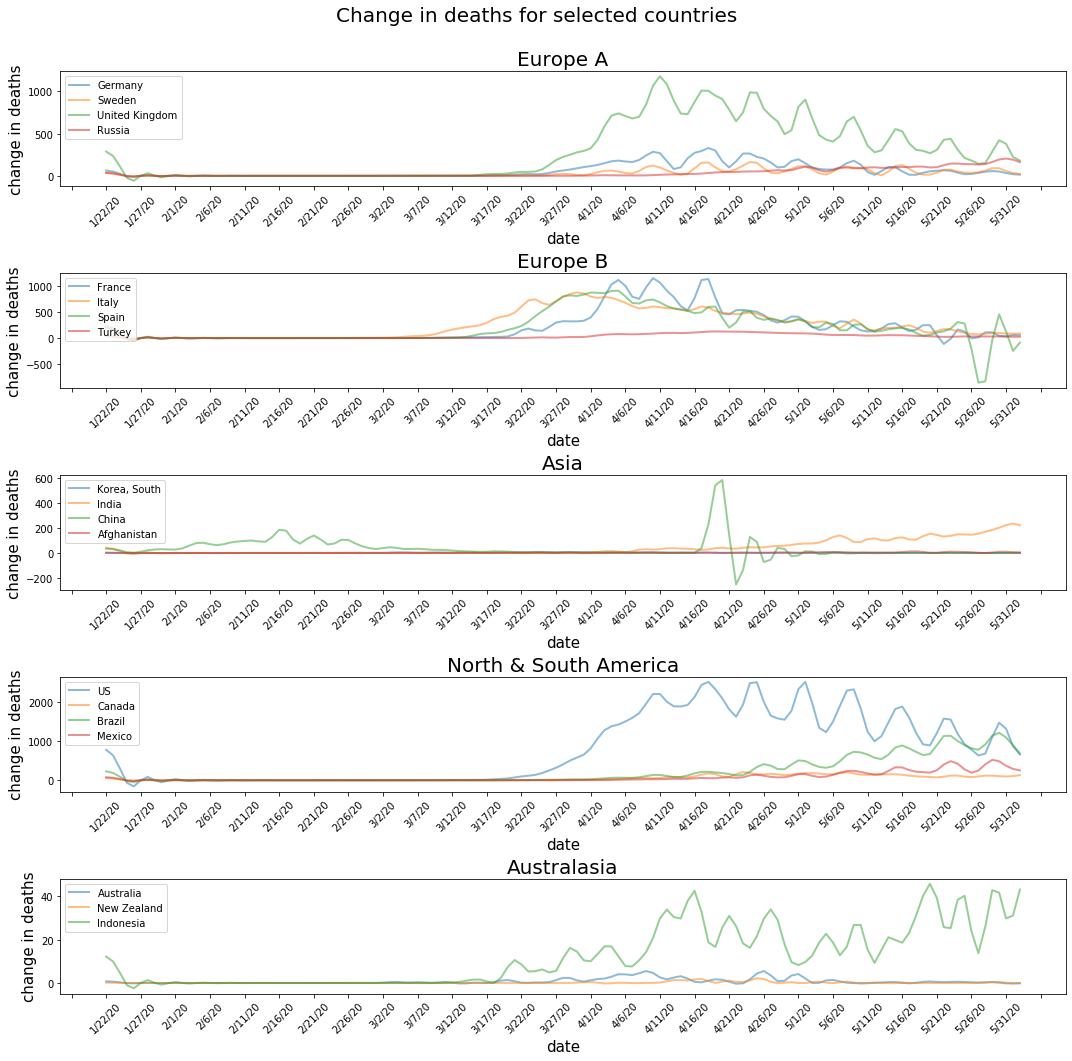

In [147]:
labels = ['change in deaths', 'Change in deaths']
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [Ts, order, cutoff]
plotResults(changes_deaths_df, x, labels, dict_candidates, filterInputs_ = filterInputs)

#### ------------------------------------------------------ Visualisation: Country Bar plots -----------------------------------------------------------------------------------

##### 2.5 Total Cases - Single bar plots

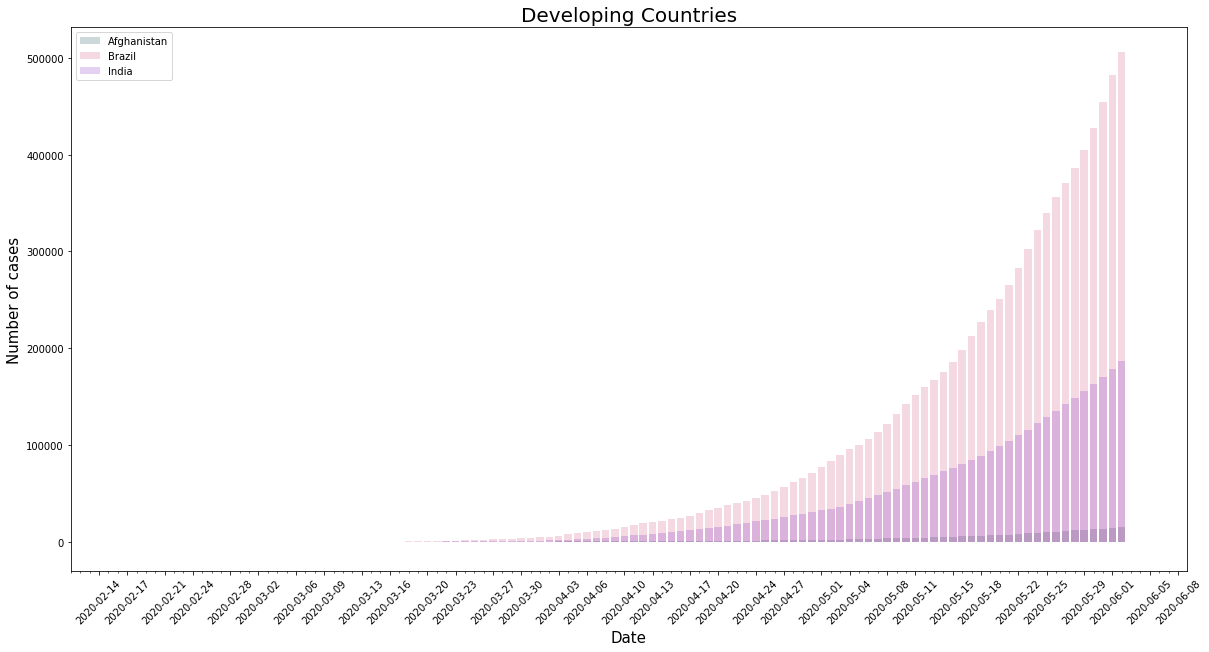

In [148]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'New Zealand', 'Indonesia'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of cases", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]
    
    

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())

filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(conf_df, list_countries, colourList, labels, filterInputs)

#### 2.6. New cases per day - Single bar plots

In [149]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'New Zealand', 'Indonesia'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of cases", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Changes in cases", "Change in new cases per day"]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(changes_conf_df, list_countries, colourList, axislabels, filterInputs)

##### 2.5 Total deaths - Single bar plots

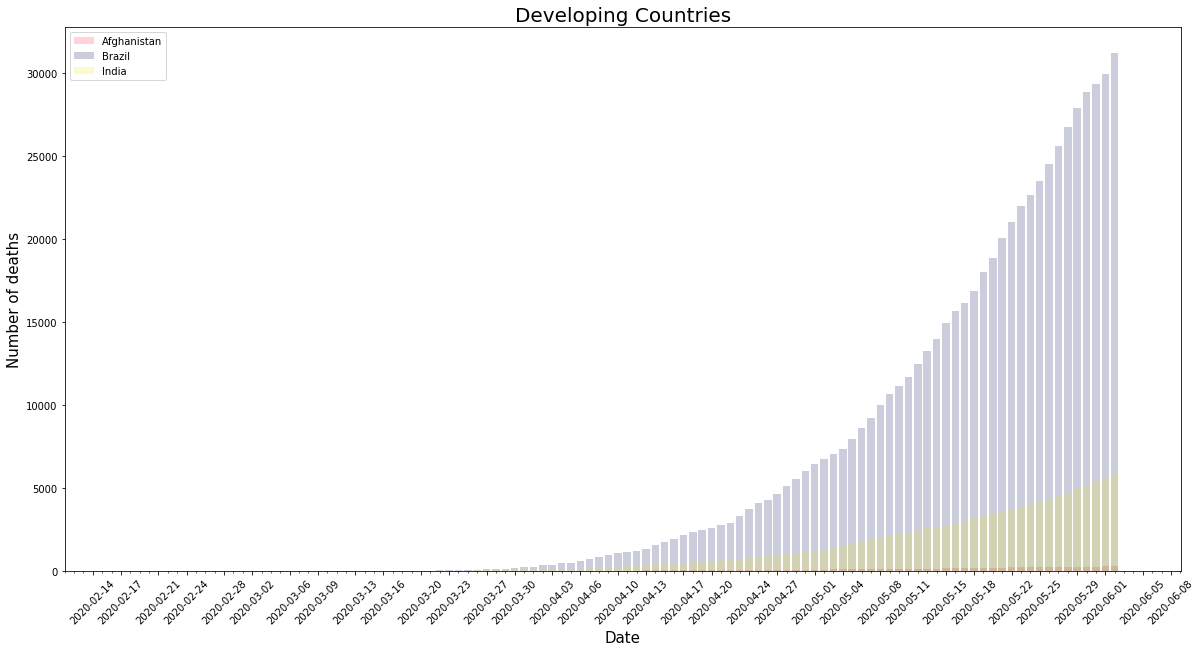

In [154]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'New Zealand', 'Indonesia'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of deaths", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]
    
    

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())

filtering = False
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(deaths_df_less_states, list_countries, colourList, labels, filterInputs)

#### 2.6. New deaths per day - Single bar plots

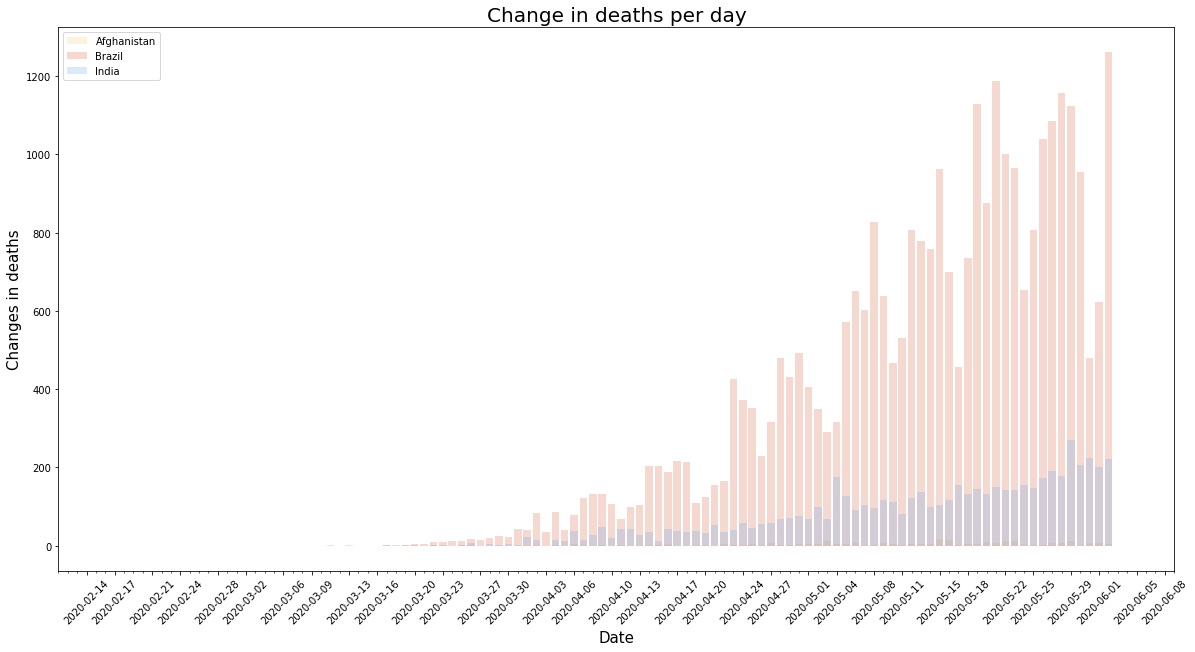

In [151]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'New Zealand', 'Indonesia'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of cases", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Changes in deaths", "Change in deaths per day"]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(changes_deaths_df, list_countries, colourList, axislabels, filterInputs)

#### 3. Basic quick predictions ------------------------------------------------------------------------------------------------------------------------------------------------

#### 3.1 Polynomial regression - 'n' degrees

- Selected countries 

#### 3.1.1 Total number of cases

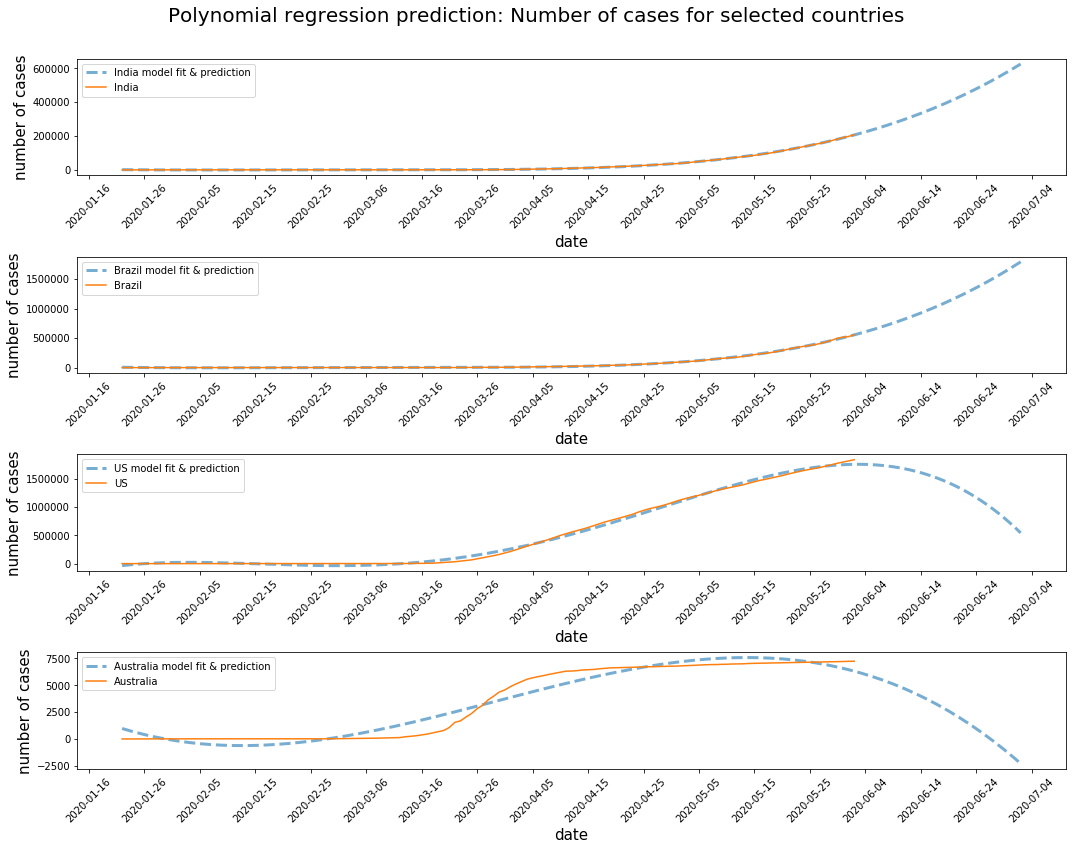

In [153]:
labels = ['number of cases', 'Polynomial regression prediction: Number of cases']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [4, 4, 4, 4]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(conf_df_less_states, labels, countryList, degreeList, prediction_window)

#### 3.1.2 Total number of deaths

In [155]:
labels = ['number of deaths', 'Polynomial regression prediction: Number of deaths']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [4, 4, 4, 4]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(deaths_df_less_states, labels, countryList, degreeList, prediction_window)

#### 3.1.3 Change in number of cases

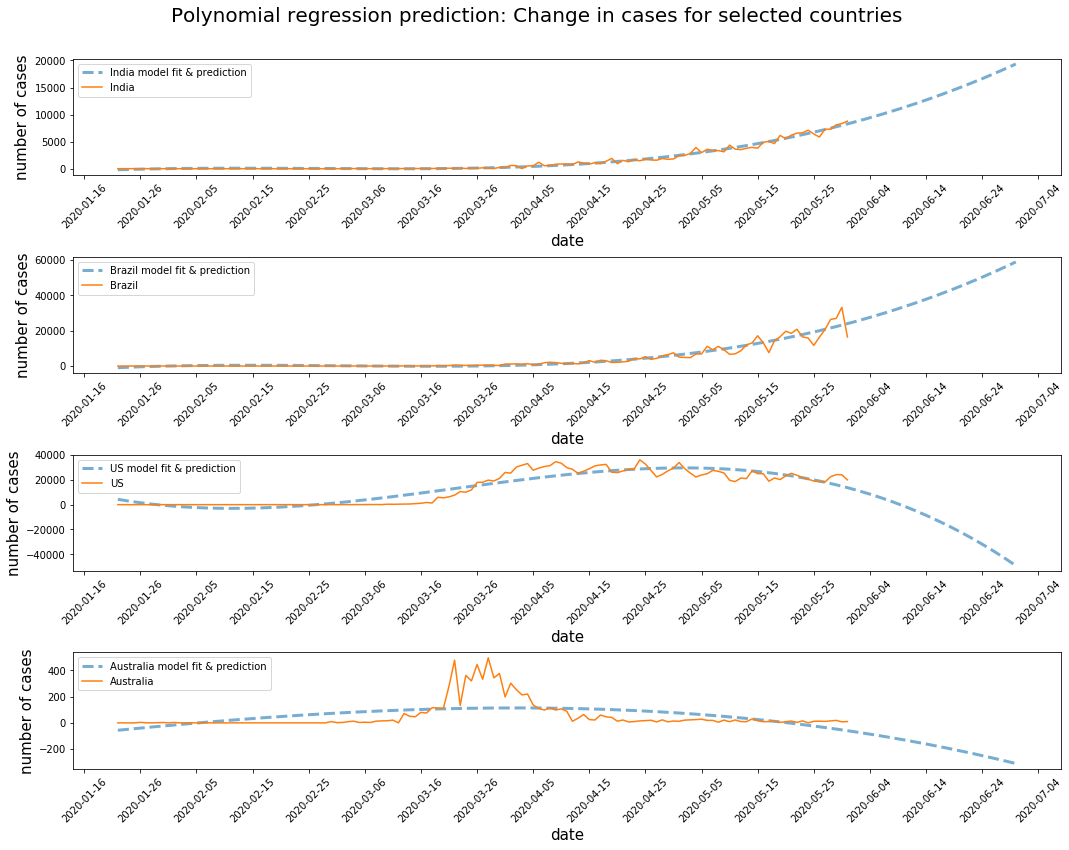

In [112]:
labels = ['number of cases', 'Polynomial regression prediction: Change in cases']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [3, 3, 3, 3]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(changes_conf_df, labels, countryList, degreeList, prediction_window)

#### 3.1.4 Change in number of deaths

In [110]:
labels = ['change indeaths', 'Polynomial regression prediction: Change in deaths']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [4, 4, 4, 4]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(changes_deaths_df, labels, countryList, degreeList, prediction_window)

- Predictions seem a little too optimistic for the US

#### 3.2 Gaussian process regression - with specified kernel 

- Really quite bad predicting the absolute number of cases/deaths!

#### 3.2.1 Number of cases

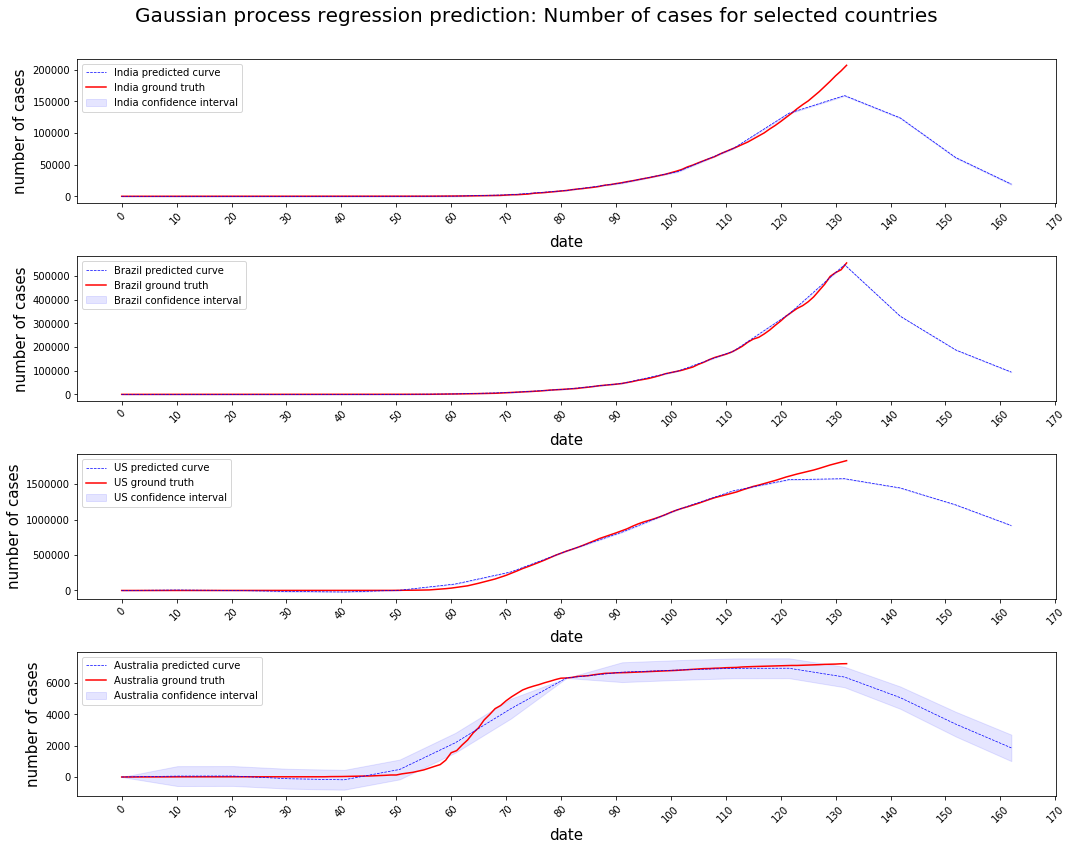

In [156]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
countryList = ['India', 'Brazil', 'US', 'Australia']
labels = ['number of cases', 'Gaussian process regression prediction: Number of cases']
prediction_window = 30
kernel = kernels[1]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(conf_df_less_states, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

#### 3.2.2 Number of deaths

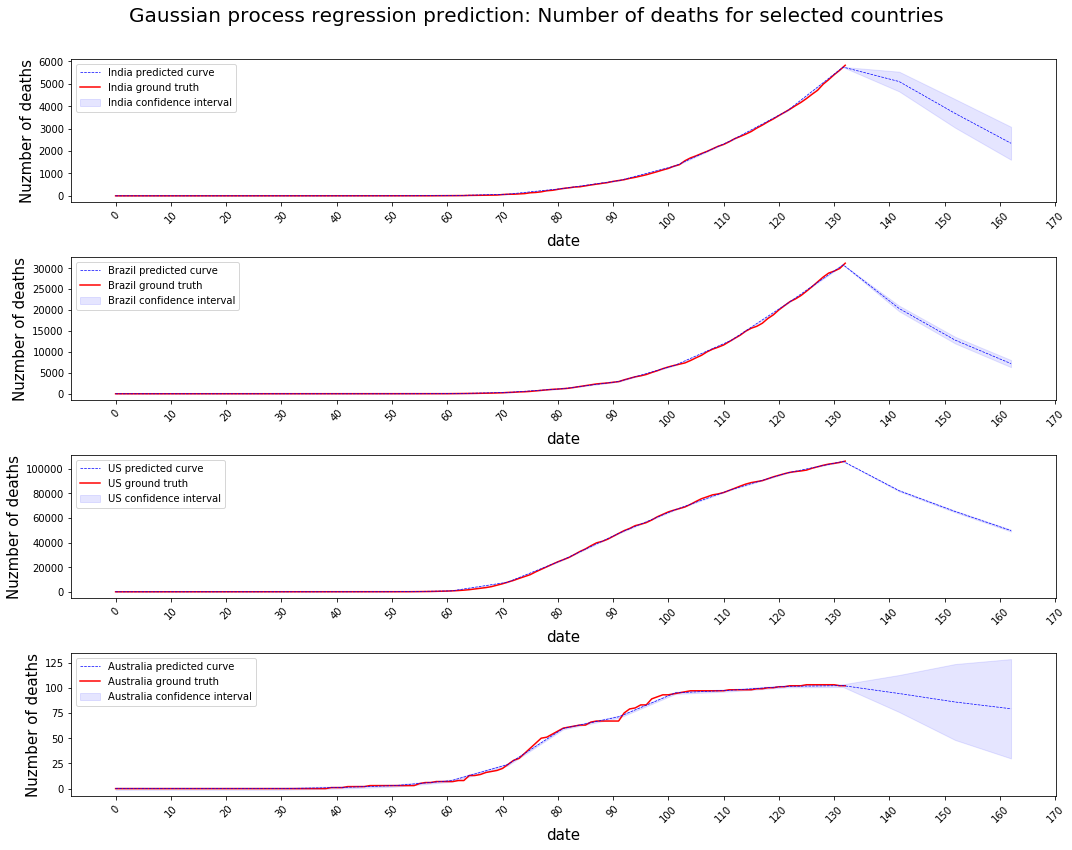

In [157]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
labels = ['Nuzmber of deaths', 'Gaussian process regression prediction: Number of deaths']
#gpm = GaussianProcessRegressor(kernel=kk, n_restarts_optimizer=3, alpha=alphaNoise)
prediction_window = 30
kernel = kernels[1]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(deaths_df_less_states, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

#### 3.2.3 Change in number of cases

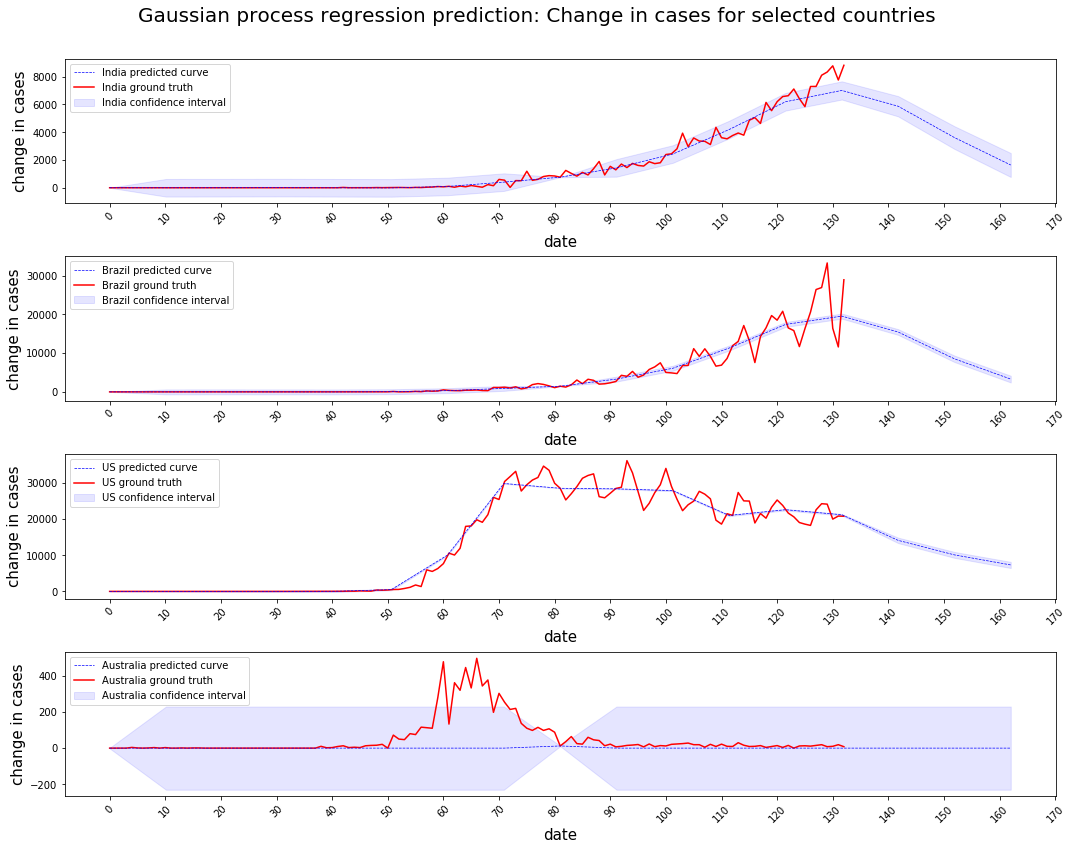

In [158]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
labels = ['change in cases', 'Gaussian process regression prediction: Change in cases']
#gpm = GaussianProcessRegressor(kernel=kk, n_restarts_optimizer=3, alpha=alphaNoise)
prediction_window = 30
kernel = kernels[1]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(changes_conf_df, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

- Predictions appear overly optimistic!

#### 3.2.4 Change in number of deaths 

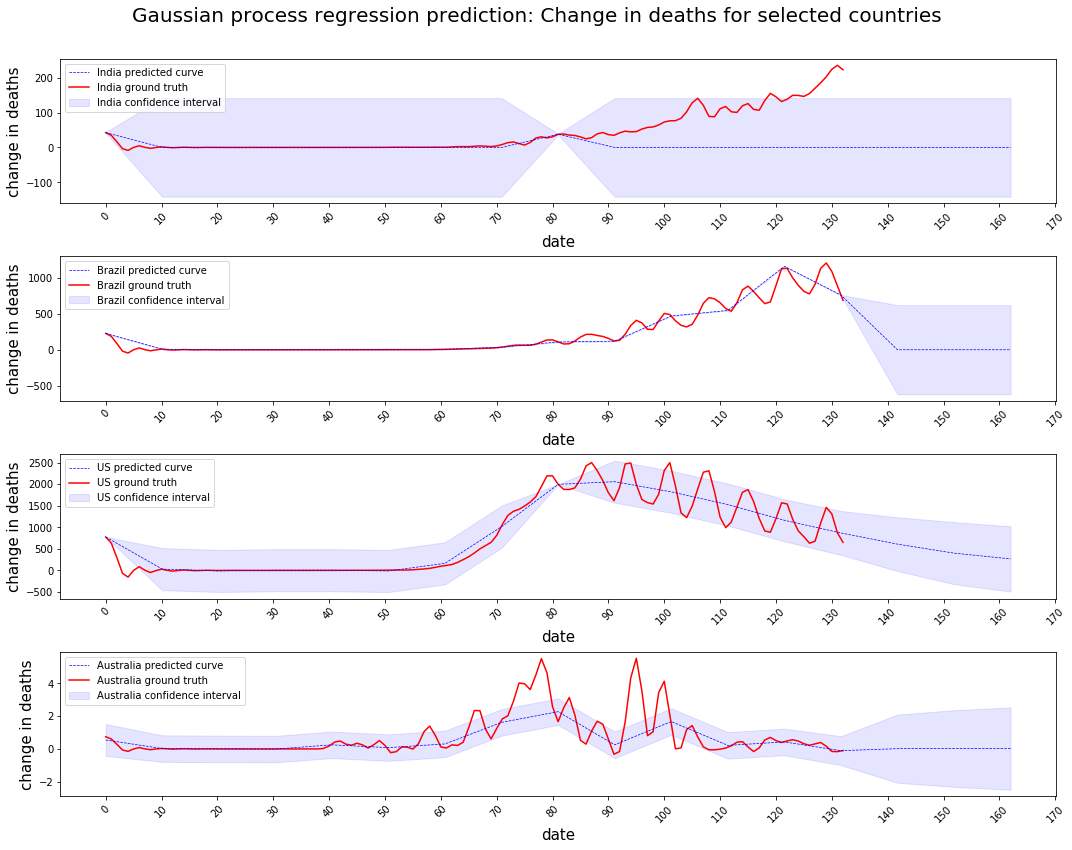

In [159]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
labels = ['change in deaths', 'Gaussian process regression prediction: Change in deaths']
#gpm = GaussianProcessRegressor(kernel=kk, n_restarts_optimizer=3, alpha=alphaNoise)
prediction_window = 30
kernel = kernels[1]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(changes_deaths_df, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

#### 3.3 Multi-step time-series forecasting

#### 3.3.1 Setup single-step test model to find ideal number of lags to include

- Unpivot dataframe from wide to long format
- Trial selected few countries: 'Brazil', 'Mexico', 'US', 'Ecuador', 'India'
- Test basic Random Forest regression model with n-lags: Find optimal number of lags for regression

In [112]:
df_country = conf_df[(conf_df['Province/State'] == 'Brazil') | (conf_df['Province/State'] == 'Mexico') | 
                     (conf_df['Province/State'] == 'US') | (conf_df['Province/State'] == 'Ecuador') |
                     (conf_df['Province/State'] == 'India')]
df_country.drop(df_country.columns[1:4], axis = 1, inplace = True)
cols = ['Province/State']
cols = np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]), dtype = int)
cols = cols.astype('U')
cols = cols.tolist()
cols.insert(0,'Province/State')
df_country.columns = cols #np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]))
df_country.reset_index(drop = True, inplace = True)
df_country.head()

Province/State  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  \
0         Brazil  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
1        Ecuador  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
2          India  0  0  0  0  0  0  0  0  1   1   1   2   3   3   3   3   3   
3         Mexico  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
4             US  1  1  2  2  5  5  5  5  5   7   8   8  11  11  11  11  11   

   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4  11  11  11  12  12  13  13  13  13  13  13  13  13  15  15  15  51  51  57   

   37  38  39  40  41   42   43   44   45   46   47   48   49    50    51  \
0   1   1   2   2   2    2    4    4   13   13   20   25   31    38    52   
1   0   0   0   6   6    7   10   13   13   13   14   15   15    17    17   
2   3   3   3   3   5    5   28   30   31   34   39   43   56    62    73   
3   0   1   4   5   5    5    5    5    6    6    7    7    7     8    12   
4  58  60  68  74  98  118  149  219  267  403  519  588  962  1285  1667   

     52    53    54    55    56    57     58     59     60     61     62  \
0   151   151   162   200   321   372    621    793   1021   1546   1924   
1    17    28    28    37    58   111    199    367    506    789    981   
2    82   102   113   119   142   156    194    244    330    396    499   
3    26    41    53    82    93   118    164    203    251    316    367   
4  2181  2729  3536  4661  6437  7781  13748  19274  25600  33280  43862   

      63     64     65      66      67      68      69      70      71  \
0   2247   2554   2985    3417    3904    4256    4579    5717    6836   
1   1082   1173   1403    1595    1823    1924    1962    2240    2748   
2    536    657    727     887     987    1024    1251    1397    1998   
3    405    475    585     717     848     993    1094    1215    1378   
4  53925  65844  83836  101962  121786  140910  162147  188172  213602   

       72      73      74      75      76      77      78      79      80  \
0    8044    9056   10360   11130   12161   14034   16170   18092   19638   
1    3163    3368    3465    3646    3747    3747    4450    4965    7161   
2    2543    2567    3082    3588    4778    5311    5916    6725    7598   
3    1510    1688    1890    2143    2439    2785    3181    3441    3844   
4  244008  275798  309027  336802  366317  397121  428654  463327  496846   

       81      82      83      84      85      86      87      88      89  \
0   20727   22192   23430   25262   28320   30425   33682   36658   38654   
1    7257    7466    7529    7603    7858    8225    8450    9022    9468   
2    8446    9205   10453   11487   12322   13430   14352   15722   17615   
3    4219    4661    5014    5399    5847    6297    6875    7497    8261   
4  526776  555313  580624  607670  636674  667981  700062  732590  758809   

       90      91      92      93      94      95      96      97       98  \
0   40743   43079   45757   50036   54043   59324   63100   67446    73235   
1   10128   10398   10850   11183   22719   22719   22719   23240    24258   
2   18539   20080   21370   23077   24530   26283   27890   29451    31324   
3    8772    9501   10544   11633   12872   13842   14677   15529    16752   
4  784708  811865  840351  869170  905358  938154  965785  988197  1012582   

        99      100      101      102      103      104      105      106  \
0    79685    87187    92202    97100   101826   108620   115455   126611   
1    24675    24934    26336    27464    29538    31881    31881    31881   
2    33062    34863    37257    39699    42505   

- Convert categorical variable 'Province/State' to numerical

In [113]:
cat_vars = df_country.dtypes[df_country.dtypes == "object"].index
for i, var in enumerate(cat_vars):
    #print(var)
    df_country[var] = df_country[var].astype('category')
    df_country[var] = df_country[var].cat.codes

In [114]:
df_country = df_country.melt(id_vars='Province/State', var_name='Day', value_name='Cases')
df_country['Day'] = df_country['Day'].str.extract('(\d+)', expand=False).astype(int)
df_country = df_country.sort_values(['Day', 'Province/State'])
df_country.head()

Province/State  Day  Cases
0               0    1      0
1               1    1      0
2               2    1      0
3               3    1      0
4               4    1      1

**Create baseline & Test**: (Need to be able to estimate better than this)
- Assume model predicts "tomorrow's cases" as "yesterday's cases"

In [76]:
mean_error = []
for day in range(110, len(conf_df.columns)-3):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    p = val['yesterday_cases'].values

    error = rmsle(val['Cases'].values, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 110 - Error 0.04197,  Day 111 - Error 0.03462,  Day 112 - Error 0.04209,  Day 113 - Error 0.04272,  Day 114 - Error 0.04602,  Day 115 - Error 0.05091,  Day 116 - Error 0.04574,  Day 117 - Error 0.03504,  Day 118 - Error 0.04047,  Day 119 - Error 0.04593,  Day 120 - Error 0.04418,  Day 121 - Error 0.04413,  Day 122 - Error 0.04457,  Day 123 - Error 0.04016,  Day 124 - Error 0.03687,  Day 125 - Error 0.03070,  Day 126 - Error 0.03392,  Day 127 - Error 0.03856,  Day 128 - Error 0.03991,  Day 129 - Error 0.03888,  Day 130 - Error 0.04071,  Day 131 - Error 0.03110,  Day 132 - Error 0.02504,  Mean Error = 0.03975


**Trial models with varying numbers of lags and see how they all perform**

- **1 lag**: See how model performs

In [68]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
df_country_.dropna(inplace = True)

#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 103 - Error 0.03276,  Day 104 - Error 0.02976,  Day 105 - Error 0.05704,  Day 106 - Error 0.03280,  Day 107 - Error 0.06001,  Day 108 - Error 0.07683,  Day 109 - Error 0.04749,  Day 110 - Error 0.06244,  Day 111 - Error 0.04436,  Day 112 - Error 0.01949,  Day 113 - Error 0.02876,  Day 114 - Error 0.02627,  Day 115 - Error 0.06053,  Day 116 - Error 0.05031,  Day 117 - Error 0.03216,  Day 118 - Error 0.03850,  Day 119 - Error 0.03866,  Day 120 - Error 0.04228,  Day 121 - Error 0.02090,  Day 122 - Error 0.02250,  Day 123 - Error 0.04117,  Day 124 - Error 0.04375,  Day 125 - Error 0.04723,  Day 126 - Error 0.03003,  Day 127 - Error 0.02155,  Day 128 - Error 0.01534,  Day 129 - Error 0.02691,  Day 130 - Error 0.03195,  Day 131 - Error 0.02578,  Day 132 - Error 0.03967,  Mean Error = 0.03824


- **2 lags**: See if improvement ensures

In [71]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()
df_country_ = df_country_.dropna()

#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 103 - Error 0.02978,  Day 104 - Error 0.03225,  Day 105 - Error 0.05490,  Day 106 - Error 0.03021,  Day 107 - Error 0.04374,  Day 108 - Error 0.04742,  Day 109 - Error 0.03424,  Day 110 - Error 0.05133,  Day 111 - Error 0.03952,  Day 112 - Error 0.02870,  Day 113 - Error 0.03017,  Day 114 - Error 0.02752,  Day 115 - Error 0.05294,  Day 116 - Error 0.05079,  Day 117 - Error 0.02972,  Day 118 - Error 0.03557,  Day 119 - Error 0.04026,  Day 120 - Error 0.04228,  Day 121 - Error 0.02575,  Day 122 - Error 0.02357,  Day 123 - Error 0.03330,  Day 124 - Error 0.04302,  Day 125 - Error 0.04507,  Day 126 - Error 0.03796,  Day 127 - Error 0.01929,  Day 128 - Error 0.01329,  Day 129 - Error 0.02138,  Day 130 - Error 0.03192,  Day 131 - Error 0.02295,  Day 132 - Error 0.04200,  Mean Error = 0.03536


- **3 lags**: See if improvement ensures

In [74]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()

df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()

df_country_['Last-2_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(3)
df_country_['Last-2_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-2_yesterday_cases'].diff()
df_country_ = df_country_.dropna()
 
    
#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 103 - Error 0.03099,  Day 104 - Error 0.03117,  Day 105 - Error 0.04560,  Day 106 - Error 0.03449,  Day 107 - Error 0.05270,  Day 108 - Error 0.04286,  Day 109 - Error 0.03143,  Day 110 - Error 0.04725,  Day 111 - Error 0.03946,  Day 112 - Error 0.02716,  Day 113 - Error 0.02589,  Day 114 - Error 0.02815,  Day 115 - Error 0.04626,  Day 116 - Error 0.04638,  Day 117 - Error 0.03609,  Day 118 - Error 0.03712,  Day 119 - Error 0.04213,  Day 120 - Error 0.03960,  Day 121 - Error 0.02996,  Day 122 - Error 0.02635,  Day 123 - Error 0.03640,  Day 124 - Error 0.04193,  Day 125 - Error 0.05111,  Day 126 - Error 0.04127,  Day 127 - Error 0.02436,  Day 128 - Error 0.02022,  Day 129 - Error 0.02046,  Day 130 - Error 0.03093,  Day 131 - Error 0.02413,  Day 132 - Error 0.04027,  Mean Error = 0.03574


- Error increased: Therefore 2 lags appeared to perform best!

- **4 lags**: Double check this also worsens

In [90]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()

df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()

df_country_['Last-2_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(3)
df_country_['Last-2_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-2_yesterday_cases'].diff()

df_country_['Last-3_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(4)
df_country_['Last-3_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-3_yesterday_cases'].diff()

df_country_ = df_country_.dropna()

#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values
    print (xts)
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

     Province/State  Day  yesterday_cases  yesterday_cases_diff  \
510               0  103          97100.0                4898.0   
511               1  103          27464.0                1128.0   
512               2  103          39699.0                2442.0   
513               3  103          22088.0                1349.0   
514               4  103        1132539.0               29078.0   

     Last-1_yesterday_cases  Last-1_yesterday_case_Diff  \
510                 92202.0                      5015.0   
511                 26336.0                      1402.0   
512                 37257.0                      2394.0   
513                 20739.0                      1515.0   
514               1103461.0                     34037.0   

     Last-2_yesterday_cases  Last-2_yesterday_case_Diff  \
510                 87187.0                      7502.0   
511                 24934.0                       259.0   
512                 34863.0                      1801.0   
513   

KeyboardInterrupt: 

- Error increased further for 4 lags

#### 3.3.2 Construct multi-step time-series forecasting model for selected countries

In [216]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()
df_country_ = df_country_.dropna()

# Move target to end
cols = list(df_country_)
cols.insert(len(cols)-1, cols.pop(cols.index('Cases')))
df_country_ = df_country_[cols]

#### Predict with multi-step model with given prediction-window:  
prediction_window = 50
start = len(conf_df.columns)-3
end = len(conf_df.columns)-3 + prediction_window

for day in range(start, end):
    print('Day = {}'.format(day), end = ', ')
    
    train = df_country_[df_country_['Day'] < day]
    xtr = train.drop(['Cases'], axis=1)
    ytr = train['Cases'].values
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    # Prepare prediction dataframe: (New day to be predicted)
    col_0 = [0, 1, 2, 3, 4]                                                                # 'Province/State'
    col_1 = [day]*5                                                                        #  'Day'
    col_2 = df_country_.Cases.tail(5).values.tolist()                                      # 'yesterday_cases'
    col_3 = (df_country_.Cases.tail(5) - df_country_.Cases.tail(10).values[0:5]).tolist()  # 'yesterday_cases_diff'
    col_4 = df_country_.yesterday_cases.tail(10).values[0:5].tolist()                      # 'Last-1_yesterday_cases'                      # 
    col_5 = df_country_.yesterday_cases_diff.tail(5).values.tolist()                       # 'Last-1_yesterday_case_Diff'
    data = [col_0, col_1, col_2, col_3, col_4, col_5]
    df_pred = pd.DataFrame(data) 
    df_pred = df_pred.transpose() 
    df_pred.columns = df_country_.columns[:-1]
    
    # Predict next set of cases
    p = mdl.predict(df_pred)
    df_pred['Cases'] = p

    # concatenate new dataframe to end & reset index:
    df_country_ = pd.concat([df_country_, df_pred])
    df_country_.reset_index(drop = True, inplace = True)


Day = 133, Day = 134, Day = 135, Day = 136, Day = 137, Day = 138, Day = 139, Day = 140, Day = 141, Day = 142, Day = 143, Day = 144, Day = 145, Day = 146, Day = 147, Day = 148, Day = 149, Day = 150, Day = 151, Day = 152, Day = 153, Day = 154, Day = 155, Day = 156, Day = 157, Day = 158, Day = 159, Day = 160, Day = 161, Day = 162, Day = 163, Day = 164, Day = 165, Day = 166, Day = 167, Day = 168, Day = 169, Day = 170, Day = 171, Day = 172, Day = 173, Day = 174, Day = 175, Day = 176, Day = 177, Day = 178, Day = 179, Day = 180, Day = 181, Day = 182, 

- Plot outcomes of all 5 results: 

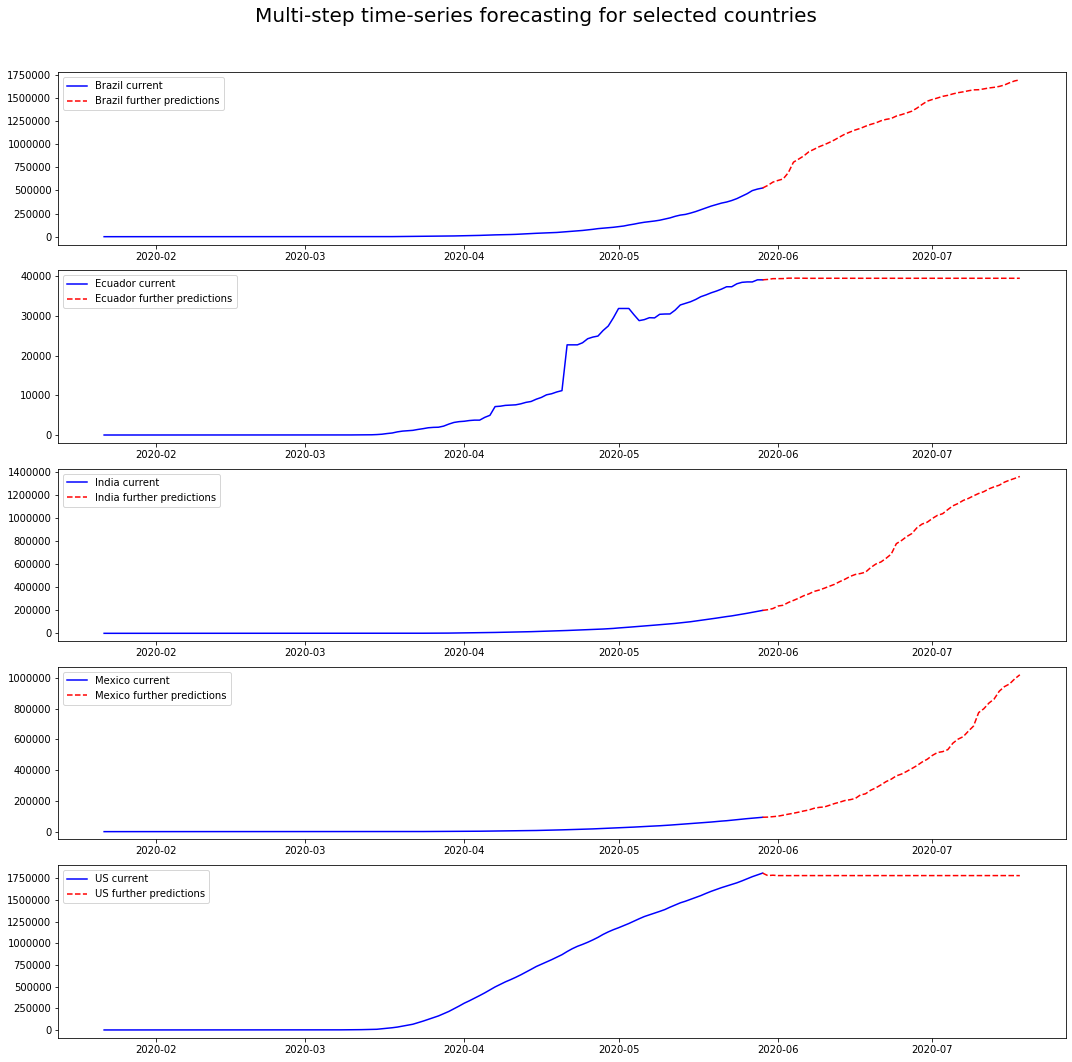

In [237]:
f = plt.figure(figsize=(15,15))
base = datetime.date(2020, 1, 22)
numdays = len(conf_df.columns[5:]) + 50 - 2
date_list_pred = [base + datetime.timedelta(days=x) for x in range(numdays)]
labels = ['Brazil', 'Ecuador', 'India', 'Mexico', 'US']

for i in range(len(df_country_['Province/State'].unique())):
    axi = f.add_subplot(str(len(df_country_['Province/State'].unique())) +"1" + str(i + 1))
    df_= df_country_[df_country_['Province/State'] == i]
    
    plt.plot(date_list_pred[0:-50], df_['Cases'][0:-50],  'b-', label = labels[i] + ' current')
    plt.plot(date_list_pred[-51:], df_['Cases'].tail(51),  'r--', label = labels[i] + ' further predictions')
    plt.legend()
    
ret = plt.suptitle("Multi-step time-series forecasting for selected countries", size = 20)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

#### 3.3.3 Construct multi-step time-series forecasting model for all given countries

In [186]:
df_country = conf_df_less_states.copy()
df_country.drop(df_country.columns[1:4], axis = 1, inplace = True)
cols = ['Province/State']
cols = np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]), dtype = int)
cols = cols.astype('U')
cols = cols.tolist()
cols.insert(0,'Province/State')
df_country.columns = cols #np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]))
df_country.reset_index(drop = True, inplace = True)

#### Categorical variables to numerical
le = LabelEncoder()
cat_vars = df_country.dtypes[df_country.dtypes == "object"].index
for var in cat_vars:
      df_country[var] = le.fit_transform(df_country[var])

#### Unpivot dataframe    
df_country = df_country.melt(id_vars='Province/State', var_name='Day', value_name='Cases')
df_country['Day'] = df_country['Day'].str.extract('(\d+)', expand=False).astype(int)
df_country = df_country.sort_values(['Day', 'Province/State'])
df_country.reset_index(drop = True, inplace = True)


#### Add lags (2 appeared optimal)
df_country['yesterday_cases'] = df_country.groupby(['Province/State'])['Cases'].shift()
df_country['yesterday_cases_diff'] = df_country.groupby(['Province/State'])['yesterday_cases'].diff()
df_country['Last-1_yesterday_cases'] = df_country.groupby(['Province/State'])['Cases'].shift(2)
df_country['Last-1_yesterday_case_Diff'] = df_country.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()
df_country.dropna(inplace = True)
df_country.sort_values(by = ['Day', 'Province/State'], inplace = True)
df_country.head(10)

Province/State  Day  Cases  yesterday_cases  yesterday_cases_diff  \
642               0    4      0              0.0                   0.0   
643               1    4      0              0.0                   0.0   
644               2    4      0              0.0                   0.0   
645               3    4      0              0.0                   0.0   
646               4    4      0              0.0                   0.0   
647               5    4      0              0.0                   0.0   
648               6    4      0              0.0                   0.0   
649               7    4      0              0.0                   0.0   
650               8    4      0              0.0                   0.0   
651               9    4      0              0.0                   0.0   

     Last-1_yesterday_cases  Last-1_yesterday_case_Diff  
642                     0.0                         0.0  
643                     0.0                         0.0  
644                     0.0                         0.0  
645                     0.0                         0.0  
646                     0.0                         0.0  
647                     0.0                         0.0  
648                     0.0                         0.0  
649                     0.0                         0.0  
650                     0.0                         0.0  
651                     0.0                         0.0

In [196]:
# Move target to end
df_country_ = df_country.copy()
cols = list(df_country_)
cols.insert(len(cols)-1, cols.pop(cols.index('Cases')))
df_country_ = df_country_[cols]

#### Predict with multi-step model with given prediction-window:  
prediction_window = 50
start = len(conf_df.columns)-3
end = len(conf_df.columns)-3 + prediction_window

for day in range(start, end):
    print('Day = {}'.format(day), end = ', ')
    
    train = df_country_[df_country_['Day'] < day]
    xtr = train.drop(['Cases'], axis=1)
    ytr = train['Cases'].values
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    # Prepare prediction dataframe: (New day to be predicted)
    maxVal = int(max(df_country['Province/State'].unique()))
    col_0 = list(range(0, maxVal))                                                              # 'Province/State'
    col_1 = [day]*maxVal                                                                        #  'Day'
    col_2 = df_country_.Cases.tail(maxVal).values.tolist()                                      # 'yesterday_cases'
    col_3 = (df_country_.Cases.tail(maxVal) - df_country_.Cases.tail(maxVal * 2 ).values[0:maxVal]).tolist()  # 'yesterday_cases_diff'
    col_4 = df_country_.yesterday_cases.tail(2 * maxVal).values[0:maxVal].tolist()                      # 'Last-1_yesterday_cases'                      # 
    col_5 = df_country_.yesterday_cases_diff.tail(maxVal).values.tolist()                       # 'Last-1_yesterday_case_Diff'
    data = [col_0, col_1, col_2, col_3, col_4, col_5]
    df_pred = pd.DataFrame(data) 
    df_pred = df_pred.transpose() 
    df_pred.columns = df_country_.columns[:-1]
    
    # Predict next set of cases
    p = mdl.predict(df_pred)
    df_pred['Cases'] = p

    # concatenate new dataframe to end & reset index:
    df_country_ = pd.concat([df_country_, df_pred])
    df_country_.reset_index(drop = True, inplace = True)
    
df_country_[var] = le.inverse_transform(df_country_[var].astype(int))

Day = 134, Day = 135, Day = 136, Day = 137, Day = 138, Day = 139, Day = 140, Day = 141, Day = 142, Day = 143, Day = 144, Day = 145, Day = 146, Day = 147, Day = 148, Day = 149, Day = 150, Day = 151, Day = 152, Day = 153, Day = 154, Day = 155, Day = 156, Day = 157, Day = 158, Day = 159, Day = 160, Day = 161, Day = 162, Day = 163, Day = 164, Day = 165, Day = 166, Day = 167, Day = 168, Day = 169, Day = 170, Day = 171, Day = 172, Day = 173, Day = 174, Day = 175, Day = 176, Day = 177, Day = 178, Day = 179, Day = 180, Day = 181, Day = 182, Day = 183, 

In [208]:
(df_country_.Cases.tail(maxVal) - df_country_.Cases.tail(maxVal * 2 ).values[0:maxVal]).tolist() 

[538.47680037182,
 4460.037351290433,
 636.8604143552438,
 327.86298353684106,
 -1.4146974036677307e-06,
 188.4410760921014,
 2959.391481601604,
 4495.368018633279,
 162.7812269084343,
 1452.1457253285407,
 4365.407218635155,
 2782.938134590484,
 309.84321416590683,
 5381.196010644067,
 0.048234609013888985,
 182.73878411104033,
 8887.701872226666,
 424.05404714055476,
 4.549732715020127e-07,
 181.6389704294388,
 428.01052153836827,
 266.312766775166,
 8322.287789557216,
 1.8204223906082007e-08,
 1741.9753668677076,
 3184.283781050879,
 -61.100916880881414,
 -1.7738415181156597e-09,
 228.5367236778111,
 824.2113190345663,
 645.7140513069462,
 254.0167566436876,
 197.47589654423246,
 408.85942571845953,
 206.50190438092886,
 1706.3669316828964,
 0.18243174604140222,
 125.15523061631075,
 1284.8699346548492,
 555.2916085440665,
 180.6036423320902,
 -0.004282527224859223,
 0.17876511058420874,
 3974.383522311109,
 130.1786248433532,
 282.6210808827127,
 376.23516600442963,
 436.3651554377

In [194]:
df_country_[var] = le.inverse_transform(df_country_[var].astype(int))

#### Save dataset with predictions for the next 50 days from 03.06.20

In [197]:
name = '../data/multistep_timeseries_03_06_20_predictions_50_days.csv'
df_country_.to_csv(name, index = False, index_label = False)

- Check if predictions are different for the same countries **'Brazil', 'Ecuador', 'India', 'Mexico', 'US'** now that training data increased to entire set

In [209]:
-f = plt.figure(figsize=(15,15))
base = datetime.date(2020, 1, 22)
numdays = len(conf_df.columns[5:]) + 50 - 2
date_list_pred = [base + datetime.timedelta(days=x) for x in range(numdays)]
labels = ['Australia', 'Korea, South', 'India', 'Mexico', 'US']

for i, label_ in enumerate(labels):
    axi = f.add_subplot(str(len(labels)) +"1" + str(i + 1))
    df_= df_country_[df_country_['Province/State'] == label_]
    
    plt.plot(date_list_pred[0:-50], df_['Cases'][0:-50],  'b-', label = label_ + ' current')
    plt.plot(date_list_pred[-51:], df_['Cases'].tail(51),  'r--', label = label_ + ' further predictions')
    plt.legend()
    
ret = plt.suptitle("Multi-step time-series forecasting for selected countries", size = 20)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

SyntaxError: can't assign to operator (<ipython-input-209-bdf19a8f7ac1>, line 1)

Province/State  Day  yesterday_cases  yesterday_cases_diff  \
0            61.0  2.0              0.0                   0.0   
1            62.0  2.0              0.0                   0.0   
2            78.0  2.0              0.0                   0.0   
3           167.0  2.0              0.0                   0.0   
4           252.0  2.0              0.0                   0.0   

   Last-1_yesterday_cases  Last-1_yesterday_case_Diff  Cases  
0                     0.0                         0.0    0.0  
1                     0.0                         0.0    0.0  
2                     0.0                         0.0    0.0  
3                     0.0                         0.0    0.0  
4                     0.0                         0.0    0.0

In [202]:
df_= df_country_[df_country_['Province/State'] == label_]
df_.tail(100)

Province/State    Day  yesterday_cases  yesterday_cases_diff  \
17320             US   84.0     5.806240e+05          25311.000000   
17534             US   85.0     6.076700e+05          27046.000000   
17748             US   86.0     6.366740e+05          29004.000000   
17962             US   87.0     6.679810e+05          31307.000000   
18176             US   88.0     7.000620e+05          32081.000000   
18390             US   89.0     7.325900e+05          32528.000000   
18604             US   90.0     7.588090e+05          26219.000000   
18818             US   91.0     7.847080e+05          25899.000000   
19032             US   92.0     8.118650e+05          27157.000000   
19246             US   93.0     8.403510e+05          28486.000000   
19460             US   94.0     8.691700e+05          28819.000000   
19674             US   95.0     9.053580e+05          36188.000000   
19888             US   96.0     9.381540e+05          32796.000000   
20102             US   97.0     9.657850e+05          27631.000000   
20316             US   98.0     9.881970e+05          22412.000000   
20530             US   99.0     1.012582e+06          24385.000000   
20744             US  100.0     1.039909e+06          27327.000000   
20958             US  101.0     1.069424e+06          29515.000000   
21172             US  102.0     1.103461e+06          34037.000000   
21386             US  103.0     1.132539e+06          29078.000000   
21600             US  104.0     1.158040e+06          25501.000000   
21814             US  105.0     1.180375e+06          22335.000000   
22028             US  106.0     1.204351e+06          23976.000000   
22242             US  107.0     1.229331e+06          24980.000000   
22456             US  108.0     1.257023e+06          27692.000000   
22670             US  109.0     1.283929e+06          26906.000000   
22884             US  110.0     1.309550e+06          25621.000000   
23098             US  111.0     1.329260e+06          19710.000000   
23312             US  112.0     1.347881e+06          18621.000000   
23526             US  113.0     1.369376e+06          21495.000000   
23740             US  114.0     1.390406e+06          21030.000000   
23954             US  115.0     1.417774e+06          27368.000000   
24168             US  116.0     1.442824e+06          25050.000000   
24382             US  117.0     1.467820e+06          24996.000000   
24596             US  118.0     1.486757e+06          18937.000000   
24810             US  119.0     1.508308e+06          21551.000000   
25024             US  120.0     1.528568e+06          20260.000000   
25238             US  121.0     1.551853e+06          23285.000000   
25452             US  122.0     1.577147e+06          25294.000000   
25666             US  123.0     1.600937e+06          23790.000000   
25880             US  124.0     1.622612e+06          21675.000000   
26094             US  125.0     1.643246e+06          20634.000000   
26308             US  126.0     1.662302e+06          19056.000000   
26522             US  127.0     1.680913e+06          18611.000000   
26736             US  128.0     1.699176e+06          18263.000000   
26950             US  129.0     1.721753e+06          22577.000000   
27164             US  130.0     1.746019e+06          24266.000000   
27378             US  131.0     1.770165e+06          24146.000000   
27592             US  132.0     1.790172e+06          20007.000000   
27806             US  133.0     1.811020e+06          20848.000000   
28020             US  134.0     4.890000e+02         -24073.000000   
28233             US  135.0     5.176510e+02             28.651000   
28446             US  136.0     5.290994e+02             11.448384   
28659             US  137.0     5.498683e+02             20.768914   
28872             US  138.0     5.670311e+02             17.162844   
29085             US  139.0     5.913495e+02             24.318356   
29298           

In [ ]:
df['col2'].cat.categories

In [19]:
df_country = conf_df.copy()
df_country.drop(df_country.columns[1:4], axis = 1, inplace = True)
cols = ['Province/State']
cols = np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]), dtype = int)
cols = cols.astype('U')
cols = cols.tolist()
cols.insert(0,'Province/State')
df_country.columns = cols #np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]))
df_country.reset_index(drop = True, inplace = True)

#### Categorical variables to numerical
cat_vars = df_country.dtypes[df_country.dtypes == "object"].index
for i, var in enumerate(cat_vars):
    df_country[var] = df_country[var].astype('category')
    df_country[var] = df_country[var].cat.codes

df_country[var] = df_country[var].astype('category')
df_country[var].cat.categories

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            258, 259, 260, 261, 262, 263, 264, 265, 266, 267],
           dtype='int64', length=268)

In [20]:
cat_vars

Index(['Province/State'], dtype='object')

In [52]:
df_country = conf_df.copy()
df_country.drop(df_country.columns[1:4], axis = 1, inplace = True)
cols = ['Province/State']
cols = np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]), dtype = int)
cols = cols.astype('U')
cols = cols.tolist()
cols.insert(0,'Province/State')
df_country.columns = cols #np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]))
df_country.reset_index(drop = True, inplace = True)
df_country.tail()

Province/State  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  \
268  West Bank and Gaza  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
269      Western Sahara  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
270               Yemen  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
271              Zambia  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
272            Zimbabwe  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   

     16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  \
268   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
269   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
270   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
271   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
272   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  \
268   0   0   0   0   0   0   0   0   0   0   4   7  16  16  19  26  30  30   
269   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
270   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
271   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
272   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67   68   69  \
268  31  35  38  38  39  41  44  47  48  52  59  59  59  84  91  98  109  116   
269   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    0    0   
270   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    0    0   
271   0   0   0   0   0   2   2   2   2   3   3   3  12  16  22  28   29   35   
272   0   0   0   0   0   0   0   1   3   3   3   3   3   3   5   7    7    7   

      70   71   72   73   74   75   76   77   78   79   80   81   82   83  \
268  119  134  161  194  217  237  254  261  263  263  267  268  271  273   
269    0    0    0    0    0    4    4    4    4    4    4    4    6    6   
270    0    0    0    0    0    0    0    0    0    0    1    1    1    1   
271   35   36   39   39   39   39   39   39   39   39   40   40   43   45   
272    8    8    9    9    9    9   10   11   11   11   13   14   14   17   

      84   85   86   87   88   89   90   91   92   93   94   95   96   97  \
268  284  291  294  307  313  319  329  329  335  336  340  342  342  342   
269    6    6    6    6    6    6    6    6    6    6    6    6    6    6   
270    1    1    1    1    1    1    1    1    1    1    1    1    1    1   
271   45   48   48   52   57   61   65   70   74   76   84   84   88   88   
272   17   23   23   24   25   25   25   28   28   28   29   31   31   32   

      98   99  100  101  102  103  104  105  106  107  108  109  110  111  \
268  343  344  344  353  353  353  362  371  374  375  375  375  375  375   
269    6    6    6    6    6    6    6    6    6    6    6    6    6    6   
270    1    6    6    7   10   10   12   22   25   25   34   34   51   56   
271   95   97  106  109  119  124  137  138  146  153  167  252  267  267   
272   32   32   40   40   34   34   34   34   34   34   34   35   36   36   

     112  113  114  115  116  117  118  119  120  121  122  123  124  125  \
268  375  375  375  375  376  381  388  391  398  423  423  423  423  423   
269    6    6    6    6    6    6    6    6    6    6    6    6    9    9   
270   65   70   85  106  122  128  130  167  184  197  209  212  222  233   
271  441  446  654  654  679  753  761  772  832  866  920  920  920  920   
272   36   37   37   42   42   44   46   46   48   51   51   56   56   56   

     126   127   128   129   130   131   132   133  
268  429   434   446   446   447   448   449   451  
269    9     9     9     9     9     9     9     9  
270  249   256   278   283   310   323   354   399  
271  920  1057  1057  1057  1057  1057 

In [51]:
conf_df, deaths_df = Update_Data()
conf_df[conf_df['Country/Region'] == 'France'].head(10)

100% [..........................................................] 93246 / 93246

Province/State Country/Region        Lat        Long  1/22/20  \
120                    Reunion         France -21.135100   55.247100        0   
121  Saint Pierre and Miquelon         France  46.885200  -56.315900        0   
122              French Guiana         France   3.933900  -53.125800        0   
123           French Polynesia         France -17.679700  149.406800        0   
124                 Guadeloupe         France  16.250000  -61.583300        0   
125                     France         France   8.305673    5.429018        0   
126                    Mayotte         France -12.827500   45.166200        0   
127              New Caledonia         France -20.904300  165.618000        0   
128           Saint Barthelemy         France  17.900000  -62.833300        0   
129                  St Martin         France  18.070800  -63.050100        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
120        0        0        0        0        0        0        0        0   
121        0        0        0        0        0        0        0        0   
122        0        0        0        0        0        0        0        0   
123        0        0        0        0        0        0        0        0   
124        0        0        0        0        0        0        0        0   
125        0        2        3        3        3        4        5        5   
126        0        0        0        0        0        0        0        0   
127        0        0        0        0        0        0        0        0   
128        0        0        0        0        0        0        0        0   
129        0        0        0        0        0        0        0        0   

     1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  \
120        0       0       0       0       0       0       0       0       0   
121        0       0       0       0       0       0       0       0       0   
122        0       0       0       0       0       0       0       0       0   
123        0       0       0       0       0       0       0       0       0   
124        0       0       0       0       0       0       0       0       0   
125        5       6       6       6       6       6       6       6      11   
126        0       0       0       0       0       0       0       0       0   
127        0       0       0       0       0       0       0       0       0   
128        0       0       0       0       0       0       0       0       0   
129        0       0       0       0       0       0       0       0       0   

     2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
120       0        0        0        0        0        0        0        0   
121       0        0        0        0        0        0        0        0   
122       0        0        0        0        0        0        0        0   
123       0        0        0        0        0        0        0        0   
124       0        0        0        0        0        0        0        0   
125      11       11       11       11       11       11       12       12   
126       0        0        0        0        0        0        0        0   
127       0        0        0        0        0        0        0        0   
128       0        0        0        0        0        0        0        0   
129       0        0        0        0        0        0        0        0   

     2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  \
120        0        0        0        0        0        0        0        0   
121        0        0        0        0        0        0        0        0   
122        0        0        0        0        0        0        0        0   
123        0        0        0        0        0        0        0        0   
124        0        0        0        0        0        0        0        0   
125       12       12       12       12 

In [46]:
conf_df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
vc = conf_df['Province/State'].value_counts()
vc[vc.values > 1]

Series([], Name: Province/State, dtype: int64)

In [44]:
vc = conf_df['Province/State'].value_counts()
vc[vc.values > 1]

Netherlands         2
Denmark             2
Diamond Princess    2
United Kingdom      2
France              2
Name: Province/State, dtype: int64

In [57]:
df_country[df_country['Province/State'] == 'Diamond Princess'].head(10)

Province/State  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  \
44   Diamond Princess  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   
106  Diamond Princess  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   

     17  18  19   20   21   22   23   24   25   26   27   28   29   30   31  \
44    0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   
106  61  61  64  135  135  175  175  218  285  355  454  542  621  634  634   

      32   33   34   35   36   37   38   39   40   41   42   43   44   45  \
44     0    0    0    0    0    0    0    0    0    0    0    0    0    0   
106  634  691  691  691  705  705  705  705  705  705  706  706  706  706   

      46   47   48   49   50   51   52   53   54   55   56   57   58   59  \
44     0    0    0    0    0    0    0    0    0    0    0    0    0    0   
106  706  706  706  706  706  706  706  706  706  706  706  712  712  712   

      60   61   62   63   64   65   66   67   68   69   70   71   72   73  \
44     0    0    0    0    0    0    0    0    0    0    0    0    0    0   
106  712  712  712  712  712  712  712  712  712  712  712  712  712  712   

      74   75   76   77   78   79   80   81   82   83   84   85   86   87  \
44     0    0    0    0    0    0    0    0    0    0    0    0    0    0   
106  712  712  712  712  712  712  712  712  712  712  712  712  712  712   

      88   89   90   91   92   93   94   95   96   97   98   99  100  101  \
44     0    0    0    0    0    0    0    0    0    0    0    0    0    1   
106  712  712  712  712  712  712  712  712  712  712  712  712  712  712   

     102  103  104  105  106  107  108  109  110  111  112  113  114  115  \
44     1    1    1    1    1    1    1    1    1    1    1    1    1    1   
106  712  712  712  712  712  712  712  712  712  712  712  712  712  712   

     116  117  118  119  120  121  122  123  124  125  126  127  128  129  \
44     1    1    1    1    1    1    1    1    1    1    1    1    1    1   
106  712  712  712  712  712  712  712  712  712  712  712  712  712  712   

     130  131  132  133  
44     1    1    1   -1  
106  712  712  712  712

In [55]:
conf_df[conf_df['Country/Region'] == 'Netherlands'].head(10)

Province/State Country/Region       Lat      Long  \
191  Bonaire, Sint Eustatius and Saba    Netherlands  12.17840 -68.23850   
192                           Curacao    Netherlands  12.16960 -68.99000   
193                      Sint Maarten    Netherlands  18.04250 -63.05480   
194                       Netherlands    Netherlands  52.13260   5.29130   
195                       Netherlands    Netherlands  21.40834 -53.00556   
196                             Aruba    Netherlands  12.51860 -70.03580   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
191        0        0        0        0        0        0        0        0   
192        0        0        0        0        0        0        0        0   
193        0        0        0        0        0        0        0        0   
194        0        0        0        0        0        0        0        0   
195        0        0        0        0        0        0        0        0   
196        0        0        0        0        0        0        0        0   

     1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  \
191        0        0       0       0       0       0       0       0       0   
192        0        0       0       0       0       0       0       0       0   
193        0        0       0       0       0       0       0       0       0   
194        0        0       0       0       0       0       0       0       0   
195        0        0       0       0       0       0       0       0       0   
196        0        0       0       0       0       0       0       0       0   

     2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
191       0       0        0        0        0        0        0        0   
192       0       0        0        0        0        0        0        0   
193       0       0        0        0        0        0        0        0   
194       0       0        0        0        0        0        0        0   
195       0       0        0        0        0        0        0        0   
196       0       0        0        0        0        0        0        0   

     2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  \
191        0        0        0        0        0        0        0        0   
192        0        0        0        0        0        0        0        0   
193        0        0        0        0        0        0        0        0   
194        0        0        0        0        0        0        0        0   
195        0        0        0        0        0        0        0        0   
196        0        0        0        0        0        0        0        0   

     2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  \
191        0        0        0        0        0        0       0       0   
192        0        0        0        0        0        0       0       0   
193        0        0        0        0        0        0       0       0   
194        0        0        0        1        1        6      10      18   
195        0        0        0        1        1        6      10      18   
196        0        0        0        0        0        0       0       0   

     3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  \
191       0       0       0       0       0       0       0        0        0   
192       0       0       0       0       0       0       0        0        0   
193       0       0       0       0       0       0       0        0        0   
194      24      38      82     128     188     265     321      382      503   
195      24      38      82     128     188     265     321      382      503   
196       0       0       0       0       0       0       0        0        0   

     3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  \
191        0        0        0        0        0        0        0        0   
192     

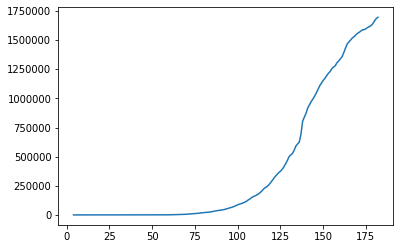

In [217]:
df_US = df_country_[df_country_['Province/State'] == 0]
plt.plot(df_US.Day, df_US.Cases)

In [60]:
df_country = conf_df[(conf_df['Province/State'] == 'Netherlands') | (conf_df['Province/State'] == 'France') | 
                     (conf_df['Province/State'] == 'Diamond Princess') | (conf_df['Province/State'] == 'United Kingdom') |
                     (conf_df['Province/State'] == 'Denmark')]
df_country.head(10)

Province/State    Country/Region        Lat       Long  1/22/20  \
44   Diamond Princess            Canada   0.000000   0.000000        0   
102           Denmark           Denmark  56.263900   9.501800        0   
105           Denmark           Denmark  63.287800 -13.338100        0   
106  Diamond Princess  Diamond Princess   0.000000   0.000000        0   
125            France            France   8.305673   5.429018        0   
131            France            France  46.227600   2.213700        0   
194       Netherlands       Netherlands  52.132600   5.291300        0   
195       Netherlands       Netherlands  21.408340 -53.005560        0   
259    United Kingdom    United Kingdom  24.548173 -43.902245        0   
263    United Kingdom    United Kingdom  55.378100  -3.436000        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
44         0        0        0        0        0        0        0        0   
102        0        0        0        0        0        0        0        0   
105        0        0        0        0        0        0        0        0   
106        0        0        0        0        0        0        0        0   
125        0        2        3        3        3        4        5        5   
131        0        2        3        3        3        4        5        5   
194        0        0        0        0        0        0        0        0   
195        0        0        0        0        0        0        0        0   
259        0        0        0        0        0        0        0        0   
263        0        0        0        0        0        0        0        0   

     1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  \
44         0       0       0       0       0       0       0       0       0   
102        0       0       0       0       0       0       0       0       0   
105        0       0       0       0       0       0       0       0       0   
106        0       0       0       0       0       0       0      61      61   
125        5       6       6       6       6       6       6       6      11   
131        5       6       6       6       6       6       6       6      11   
194        0       0       0       0       0       0       0       0       0   
195        0       0       0       0       0       0       0       0       0   
259        2       2       2       2       2       2       2       3       3   
263        2       2       2       2       2       2       2       3       3   

     2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
44        0        0        0        0        0        0        0        0   
102       0        0        0        0        0        0        0        0   
105       0        0        0        0        0        0        0        0   
106      64      135      135      175      175      218      285      355   
125      11       11       11       11       11       11       12       12   
131      11       11       11       11       11       11       12       12   
194       0        0        0        0        0        0        0        0   
195       0        0        0        0        0        0        0        0   
259       3        8        8        9        9        9        9        9   
263       3        8        8        9        9        9        9        9   

     2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  \
44         0        0        0        0        0        0        0        0   
102        0        0        0        0        0        0        0        0   
105        0        0        0        0        0        0        0        0   
106      454      542      621      634      634      634      691      691   
125       12       12       12       12       12       12       12       12   
131       12       12       12       12       12       12       12       12   
194        0        0        

In [66]:
conf_df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
df_country = conf_df[(conf_df['Country/Region'] == 'Netherlands') | (conf_df['Country/Region'] == 'France') | 
                     (conf_df['Country/Region'] == 'Diamond Princess') | (conf_df['Country/Region'] == 'United Kingdom') |
                     (conf_df['Country/Region'] == 'Denmark')]
df_country.head(500)

Province/State    Country/Region      Lat      Long  \
88                                NaN  Diamond Princess   0.0000    0.0000   
92                      Faroe Islands           Denmark  61.8926   -6.9118   
93                          Greenland           Denmark  71.7069  -42.6043   
94                                NaN           Denmark  56.2639    9.5018   
107                     French Guiana            France   3.9339  -53.1258   
108                  French Polynesia            France -17.6797  149.4068   
109                        Guadeloupe            France  16.2500  -61.5833   
110                           Mayotte            France -12.8275   45.1662   
111                     New Caledonia            France -20.9043  165.6180   
112                           Reunion            France -21.1351   55.2471   
113                  Saint Barthelemy            France  17.9000  -62.8333   
114                         St Martin            France  18.0708  -63.0501   
115                        Martinique            France  14.6415  -61.0242   
116                               NaN            France  46.2276    2.2137   
166                             Aruba       Netherlands  12.5186  -70.0358   
167                           Curacao       Netherlands  12.1696  -68.9900   
168                      Sint Maarten       Netherlands  18.0425  -63.0548   
169                               NaN       Netherlands  52.1326    5.2913   
217                           Bermuda    United Kingdom  32.3078  -64.7505   
218                    Cayman Islands    United Kingdom  19.3133  -81.2546   
219                   Channel Islands    United Kingdom  49.3723   -2.3644   
220                         Gibraltar    United Kingdom  36.1408   -5.3536   
221                       Isle of Man    United Kingdom  54.2361   -4.5481   
222                        Montserrat    United Kingdom  16.7425  -62.1874   
223                               NaN    United Kingdom  55.3781   -3.4360   
248                          Anguilla    United Kingdom  18.2206  -63.0686   
249            British Virgin Islands    United Kingdom  18.4207  -64.6400   
250          Turks and Caicos Islands    United Kingdom  21.6940  -71.7979   
255  Bonaire, Sint Eustatius and Saba       Netherlands  12.1784  -68.2385   
257       Falkland Islands (Malvinas)    United Kingdom -51.7963  -59.5236   
258         Saint Pierre and Miquelon            France  46.8852  -56.3159   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
88         0        0        0        0        0        0        0        0   
92         0        0        0        0        0        0        0        0   
93         0        0        0        0        0        0        0        0   
94         0        0        0        0        0        0        0        0   
107        0        0        0        0        0        0        0        0   
108        0        0        0        0        0        0        0        0   
109        0        0        0        0        0        0        0        0   
110        0        0        0        0        0        0        0        0   
111        0        0        0        0        0        0        0        0   
112        0        0        0        0        0        0        0        0   
113        0        0        0        0        0        0        0        0   
114        0        0        0        0        0        0        0        0   
115        0        0        0        0        0        0        0        0   
116        0        0        2        3        3        3        4        5   
166        0        0        0        0        0        0        0        0   
167        0        0        0        0        0        0        0        0   
168        0        0        0        0        0        0        0        0   
169        0        0        0        0        0        0        0        0   
217        0        0    

In [73]:
df = df_country.copy()
province_states_unique = df["Province/State"].unique()#.dropna().unique()
dfAggregates = df[df['Province/State'].isin(province_states_unique)]
country_region_aggregates = dfAggregates['Country/Region'].unique()

for i, agg_country in enumerate(country_region_aggregates):
    lstRow = []
    dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
    if dfTemp["Province/State"].isna().sum() == 0:
        if len(dfTemp) > 1:
            provState = agg_country #+ '_Total'          # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)          # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
        df = df.append(lstRow)
    else:
        df = df[(df["Province/State"].isna()) & (df['Country/Region'] == agg_country)]

df = df.sort_values(by = "Country/Region") 
df['Province/State'].fillna(df['Country/Region'], inplace=True) # Countries not including their colonial states
df = df.reset_index(drop = True)    
df.head(500)

Empty DataFrame
Columns: [Province/State, Country/Region, Lat, Long, 1/22/20, 1/23/20, 1/24/20, 1/25/20, 1/26/20, 1/27/20, 1/28/20, 1/29/20, 1/30/20, 1/31/20, 2/1/20, 2/2/20, 2/3/20, 2/4/20, 2/5/20, 2/6/20, 2/7/20, 2/8/20, 2/9/20, 2/10/20, 2/11/20, 2/12/20, 2/13/20, 2/14/20, 2/15/20, 2/16/20, 2/17/20, 2/18/20, 2/19/20, 2/20/20, 2/21/20, 2/22/20, 2/23/20, 2/24/20, 2/25/20, 2/26/20, 2/27/20, 2/28/20, 2/29/20, 3/1/20, 3/2/20, 3/3/20, 3/4/20, 3/5/20, 3/6/20, 3/7/20, 3/8/20, 3/9/20, 3/10/20, 3/11/20, 3/12/20, 3/13/20, 3/14/20, 3/15/20, 3/16/20, 3/17/20, 3/18/20, 3/19/20, 3/20/20, 3/21/20, 3/22/20, 3/23/20, 3/24/20, 3/25/20, 3/26/20, 3/27/20, 3/28/20, 3/29/20, 3/30/20, 3/31/20, 4/1/20, 4/2/20, 4/3/20, 4/4/20, 4/5/20, 4/6/20, 4/7/20, 4/8/20, 4/9/20, 4/10/20, 4/11/20, 4/12/20, 4/13/20, 4/14/20, 4/15/20, 4/16/20, 4/17/20, 4/18/20, 4/19/20, 4/20/20, 4/21/20, 4/22/20, 4/23/20, 4/24/20, 4/25/20, 4/26/20, ...]
Index: []

In [100]:
df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
df['Province/State'].fillna(df['Country/Region'], inplace=True)
listProvince = df['Province/State'].unique().tolist()
listCountry = df['Country/Region'].unique().tolist()

# Remove state entries for countries 'Australia', 'Canada' & 'China'
notAggregatedCountries = [x for x in listCountry if x not in listProvince] 
df1 = df[~df['Country/Region'].isin(notAggregatedCountries)]
print(len(df1))
for i, agg_country in enumerate(notAggregatedCountries):
    dfTemp = df[df['Country/Region'] == agg_country]
    provState = agg_country #+ '_Total'          # Countries with the sum of their states
    lat = dfTemp.Lat.sum()/len(dfTemp)          # i.e. Australia with Victoria, NSW etc aggregated
    long = dfTemp.Long.sum()/len(dfTemp)
    rowEntries = [provState, agg_country, lat, long]
    lstRow = [elem for elem in rowEntries] 
    for col in dfTemp.columns[4:]:
        col_j_aggregate = dfTemp[col].sum()
        lstRow.append(col_j_aggregate)
    lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
    df1 = df1.append(lstRow)
print(len(df1))

df1.tail(269)   

211
214


Province/State                    Country/Region  \
0                         Afghanistan                       Afghanistan   
1                             Albania                           Albania   
2                             Algeria                           Algeria   
3                             Andorra                           Andorra   
4                              Angola                            Angola   
5                 Antigua and Barbuda               Antigua and Barbuda   
6                           Argentina                         Argentina   
7                             Armenia                           Armenia   
16                            Austria                           Austria   
17                         Azerbaijan                        Azerbaijan   
18                            Bahamas                           Bahamas   
19                            Bahrain                           Bahrain   
20                         Bangladesh                        Bangladesh   
21                           Barbados                          Barbados   
22                            Belarus                           Belarus   
23                            Belgium                           Belgium   
24                              Benin                             Benin   
25                             Bhutan                            Bhutan   
26                            Bolivia                           Bolivia   
27             Bosnia and Herzegovina            Bosnia and Herzegovina   
28                             Brazil                            Brazil   
29                             Brunei                            Brunei   
30                           Bulgaria                          Bulgaria   
31                       Burkina Faso                      Burkina Faso   
32                         Cabo Verde                        Cabo Verde   
33                           Cambodia                          Cambodia   
34                           Cameroon                          Cameroon   
46           Central African Republic          Central African Republic   
47                               Chad                              Chad   
48                              Chile                             Chile   
82                           Colombia                          Colombia   
83                Congo (Brazzaville)               Congo (Brazzaville)   
84                   Congo (Kinshasa)                  Congo (Kinshasa)   
85                         Costa Rica                        Costa Rica   
86                      Cote d'Ivoire                     Cote d'Ivoire   
87                            Croatia                           Croatia   
88                   Diamond Princess                  Diamond Princess   
89                               Cuba                              Cuba   
90                             Cyprus                            Cyprus   
91                            Czechia                           Czechia   
92                      Faroe Islands                           Denmark   
93                          Greenland                           Denmark   
94                            Denmark                           Denmark   
95                           Djibouti                          Djibouti   
96                 Dominican Republic                Dominican Republic   
97                            Ecuador                           Ecuador   
98                              Egypt                             Egypt   
99                        El Salvador                       El Salvador   
100                 Equatorial Guinea                 Equatorial Guinea   
101                           Eritrea                           Eritrea   
102                           Estonia                           Estonia   
103                          Eswatini                          Eswatini   
104                          Ethiopia           

In [79]:
province_states_unique = df["Province/State"].unique()#.dropna().unique()
dfAggregates = df[df['Province/State'].isin(province_states_unique)]
country_region_aggregates = dfAggregates['Country/Region'].unique()

for i, agg_country in enumerate(country_region_aggregates):
    lstRow = []
    dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
    if dfTemp["Province/State"].isna().sum() == 0:
        if len(dfTemp) > 1:
            provState = agg_country #+ '_Total'          # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)          # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
        df = df.append(lstRow)
    else:
        df = df[(df["Province/State"].isna()) & (df['Country/Region'] == agg_country)]

df = df.sort_values(by = "Country/Region") 
df['Province/State'].fillna(df['Country/Region'], inplace=True) # Countries not including their colonial states
df = df.reset_index(drop = True)    

IndexError: list index out of range

In [ ]:

df = df_country.copy()
df = df[(df["Province/State"].isna()) & (df['Country/Region'] == agg_country)]

In [75]:
agg_country = 'France'
df = df_country.copy()
df = df[(df["Province/State"].isna()) & (df['Country/Region'] == agg_country)]
df.head()

Province/State Country/Region      Lat    Long  1/22/20  1/23/20  1/24/20  \
116            NaN         France  46.2276  2.2137        0        0        2   

     1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
116        3        3        3        4        5        5        5       6   

     2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
116       6       6       6       6       6       6      11      11       11   

     2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
116       11       11       11       11       12       12       12       12   

     2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
116       12       12       12       12       12       12       14       18   

     2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  \
116       38       57      100     130     191     204     285     377   

     3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  \
116     653     949    1126    1209     1784     2281     2281     3661   

     3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  \
116     4469     4499     6633     7652     9043    10871    12612    14282   

     3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  3/29/20  \
116    16018    19856    22304    25233    29155    32964    37575    40174   

     3/30/20  3/31/20  4/1/20  4/2/20  4/3/20  4/4/20  4/5/20  4/6/20  4/7/20  \
116    44550    52128   56989   59105   64338   68605   70478   74390   78167   

     4/8/20  4/9/20  4/10/20  4/11/20  4/12/20  4/13/20  4/14/20  4/15/20  \
116   82048   86334    90676    93790   120633   124298   129257   132473   

     4/16/20  4/17/20  4/18/20  4/19/20  4/20/20  4/21/20  4/22/20  4/23/20  \
116   144944   146923   146906   151808   154188   156921   154715   157026   

     4/24/20  4/25/20  4/26/20  4/27/20  4/28/20  4/29/20  4/30/20  5/1/20  \
116   158636   160292   160847   164589   167605   165093   165764  165764   

     5/2/20  5/3/20  5/4/20  5/5/20  5/6/20  5/7/20  5/8/20  5/9/20  5/10/20  \
116  166976  167272  167886  168935  172465  173040  174318  174758   175027   

     5/11/20  5/12/20  5/13/20  5/14/20  5/15/20  5/16/20  5/17/20  5/18/20  \
116   175479   176207   175981   176712   177319   177207   177240   177554   

     5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  5/24/20  5/25/20  5/26/20  \
116   178428   179069   179306   179645   179964   179859   180166   179887   

     5/27/20  5/28/20  5/29/20  5/30/20  5/31/20  6/1/20  6/2/20  
116   180044   183309   183816   185616   185851  185952  184980

In [197]:
df_country = conf_df[conf_df['Province/State'] == 'Australia']
y_val =  df_country[df_country.columns[4:]].values[0]
df_ = pd.DataFrame()
df_['X-Value'] = np.linspace(0, len(y_val)-1, len(y_val))
df_['Y-Value'] = y_val
df_['Y-Value_lag1'] = df_['Y-Value'].shift(1)
df_['Y-Value_lag2'] = df_['Y-Value'].shift(2)
df_.tail()

X-Value  Y-Value  Y-Value_lag1  Y-Value_lag2
126    126.0     7150        7139.0        7126.0
127    127.0     7165        7150.0        7139.0
128    128.0     7184        7165.0        7150.0
129    129.0     7192        7184.0        7165.0
130    130.0     7202        7192.0        7184.0

In [ ]:
for i in range(5, 8):
    num_lags = 2
    df_i = i
    df = returnStartingDf(num_lags, df, brew_list)

    #model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    model = LGBMRegressor(n_estimators=150, learning_rate=0.5, max_depth = 5, gamma = 0.07)

    equal_length_datasets = 1
    if equal_length_datasets:
        brew_list = brew_list_equal.copy() 

    output_interval = 20                                                      # how often to print progress                                                           # amount of lags given to model
    prediction_length = 300                                                   # how far to predict into future
    printFeatImportance = 1                                                   # print feature importances
    plotResult = 1
    df_predicted = run_prediction(output_interval, model, num_lags, df, prediction_length, printFeatImportance, plotResult)

In [ ]:
df_PCA_num = convertToPCA(train_num, 37)
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(df_PCA_num, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = df_PCA_num, n_splits = 10, model = rfModel)

In [ ]:
rf = 0
# A parameter grid for Random Forest:
if rf == 1:
    bounds = {#df_, 
            #modelType = 1
            #'min_child_weight': (1, 10),
            #'gamma': (0,1),
            #'subsample': (0.3, 1.0),
            #'colsample_bytree': (0.3, 1.0),
            'max_depth': (3, 5),
            #'learning_rate': (0.1, 0.8),
            'n_estimators':(50,150),
            }
    
# A parameter grid for LightGBM:
else:
    bounds = {#df_, 
            #modelType = 2
            #'min_child_weight': (1, 10),
            'gamma': (0,1),
            #'subsample': (0.3, 1.0),
            #'colsample_bytree': (0.3, 1.0),
            'max_depth': (3, 5),
            'learning_rate': (0.1, 0.8),
            'n_estimators':(50,150),
            }

# Define Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt2,  pbounds=bounds, random_state=1)

optimizer.maximize(init_points=10, n_iter=50)

In [ ]:
def train_bayes_opt2(#min_child_weight, 
                #df_, 
                #modelType,
                max_depth,
                gamma, 
                learning_rate, 
                #subsample, 
                #colsample_bytree,
                n_estimators):
    
    modelType = 2
    if modelType == 1:
        params = {
            #'min_child_weight': int(min_child_weight),
            'max_depth': int(max_depth),
            'n_jobs': -1,
            #'subsample':subsample,
            #'colsample_bytree':colsample_bytree,
            'n_estimators':int(n_estimators)
        }
    
    elif modelType == 2:
        
            params = {
            #'min_child_weight': int(min_child_weight),
            'max_depth': int(max_depth),
            'gamma': gamma,
            'learning_rate':learning_rate,
            #'subsample':subsample,
            #'colsample_bytree':colsample_bytree,
            'n_estimators':int(n_estimators)
        }
            
            
    ''' Optimise on all tests until min brew cycles completed in test3 (i.e 377 cycles is max number of rows for training) '''  
    
    
  
    ''' Optimise on only tests 1 & 2 but entire datasets '''  
   
  
    SUM_avgRMSE_ALL = []
    for i, col in enumerate(df_.columns):
        if i > 0: # not Brwcycles
            dfY = df_[col]
            dfY = pd.DataFrame(dfY, dtype='float')
            y = dfY.values
            colList = df_.columns.tolist()
            colList.remove(col)
            X = df_[colList].values

            # Start optimisation
            n_splits = 3
            kf = KFold(n_splits, True, 1)
            rmseScores = []

            for train_index, test_index in kf.split(X):
                trainX, testX = X[train_index], X[test_index]
                trainy, testy = y[train_index], y[test_index]

                if modelType == 1:
                    mdl = RandomForestRegressor(**params)
                elif modelType == 2:
                    mdl = LGBMRegressor(**params, silent = True)

                mdl.fit(trainX,trainy)
                preds = mdl.predict(testX)
                #rmse = sqrt(mean_squared_error(np.exp(testy),  np.exp(preds)))
                error = rmsle(testy, preds)
                rmseScores.append(error)
                #print("rmse = ", rmse)

            avgRMSE = sum(rmseScores) / n_splits
            SUM_avgRMSE_ALL.append(avgRMSE)

    avgRMSE = sum(SUM_avgRMSE_ALL) / len(SUM_avgRMSE_ALL)

    return -avgRMSE

In [ ]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False, printOutput = True):
    
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    if printOutput:
        print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        rmsleScores.append(rmsleScore)
        if printOutput:
            print(round(rmsleScore, 2), end = ', ')
    if printOutput:
        print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
    if returnVal:
        return round(sum(rmsleScores) / n_splits, 3)

## -----------------------------------------------------------------------------------------------------------------------

def run_train_test_split(df, estimator):
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
    cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=4, n_jobs = -1)
    return cval.mean()

#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------
def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    except ValueError:
        return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   
    

#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(round(max_depth)),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(round(n_estimators))
        }
        mdl = RandomForestRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   XGBoost optimiser   -------
def optimiseXGBoost(data, pbounds_):
    
    def train_bayes_opt_XGBoost(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = xgb.XGBRegressor(**params_, silent = True)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_XGBoost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = LGBMRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = GradientBoostingRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   kNN optimiser   -------
def optimiseKNN(data, pbounds_):
    
    def train_bayes_opt_kNN(n_neighbors, leaf_size, p):
        params_ = {       
        'n_neighbors': int(round(n_neighbors)),
        'leaf_size':int(round(leaf_size)),
        'p': int(round(p))
        }
        mdl = KNeighborsRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_kNN, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['n_neighbors'] = int(round(max_params['params']['n_neighbors']))
    max_params['params']['leaf_size'] = int(round(max_params['params']['leaf_size'])) 
    max_params['params']['p'] = int(round(max_params['params']['p'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------
